# SC1015 Mini Project - Movie Film Success Prediction
In our project, we aim to determine if we can use certain variables of movies to make predictions about its success.

Our data science project determines success by the revenue earned by the movie.

Project collaborators: Cheng Yao, Jun Hao, Zane.

<img src="https://raw.githubusercontent.com/chengyaolee/SC1015-DSAI-Project/main/images/The%20Imitation%20Game.jpg" width="1000" height="500">

*The Imitation Game - A historical drama film based on the life of Alan Turing who helped crack the German Enigma code during World War II*

# Importing Libraries

In [1]:
!pip install lightgbm
!pip install xgboost
!pip install squarify 
!pip install wordcloud 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt 
import squarify
from wordcloud import WordCloud
sns.set() # set the default Seaborn style for graphics


from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import DataConversionWarning
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

import lightgbm
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


# Dataset Reading
We will be using the [movies](https://www.kaggle.com/datasets/danielgrijalvas/movies) dataset available on Kaggle.






## Dataset Description

There are **7668 rows** of movies in the CSV and **15 columns** of variables.

`name`	- Name of the movie

`rating` - Motion picture content rating system *(G, PG, PG-13 etc.)*

`genre` - The associated genre of the movie

`year` - Year the movie was released

`released` - Date the movie was released

`score` - Movie score given by critics *(0.0 - 10.0)*

`votes` - Number of fan votes

`director` - Name of the director of the movie

`writer` - Name of the writer of the movie

`star` - Name of the main star of the movie

`country` - Country the movie was originated

`budget` - Budget for the filming of the movie *(in USD)*

`gross` - Gross revenue of the movie *(in USD)*

`company` - Production company

`runtime` - Duration of the movie *(in minutes)*

## Cleaning the Data

The following changes have been made on the original dataset:

-  Added "Derek Jarman" as the `writer` for the movie "The Garden" 
-  Added "Steve Coogan" as the `writer` for the movie "The Trip" 
-  Added "Li Wei" as the `writer` for the movie "Legend of Deification" 
-  Added "Tom Logan" as the `star` for the movie "The Business of Show Business" 
-  Added "United States" as the `country` for the movie "Saw: The Final Chapter" 
-  Added "United States" as the `country` for the movie "The Wolfman" 
-  Added "United States" as the `country` for the movie "Clinton Road" 

*This data was retrieved from sources available on the internet.*

In [3]:
data = pd.read_csv("moviesclean.csv")
data.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,Trojan War,PG-13,Comedy,1997,"October 1, 1997 (Brazil)",5.7,5800.0,George Huang,Andy Burg,Will Friedle,United States,15000000.0,309.0,Daybreak,85.0
1,Madadayo,NaN,Drama,1993,"April 17, 1993 (Japan)",7.3,5100.0,Akira Kurosawa,Ishirô Honda,Tatsuo Matsumura,Japan,11900000.0,596.0,DENTSU Music And Entertainment,134.0
2,Run with the Hunted,Not Rated,Crime,2019,"June 26, 2020 (United States)",5.2,735.0,John Swab,John Swab,Ron Perlman,United States,NaN,682.0,Roxwell Films,93.0
3,The Untold Story,NaN,Comedy,2019,"January 11, 2019 (United States)",5.7,320.0,Shane Stanley,Lee Stanley,Miko Hughes,United States,NaN,790.0,Visual Arts Entertainment,104.0
4,"Love, Honor and Obey",R,Comedy,2000,"February 9, 2001 (United States)",6.5,5200.0,Dominic Anciano,Dominic Anciano,Sadie Frost,United Kingdom,NaN,1400.0,British Broadcasting Corporation (BBC),103.0


In [4]:
data.describe()

,year,score,votes,budget,gross,runtime
count,7668.000000,7665.000000,7.665000e+03,5.497000e+03,7.479000e+03,7664.000000
mean,2000.405451,6.390411,8.810850e+04,3.558988e+07,7.850054e+07,107.261613
std,11.153508,0.968842,1.633238e+05,4.145730e+07,1.657251e+08,18.581247
min,1980.000000,1.900000,7.000000e+00,3.000000e+03,3.090000e+02,55.000000
25%,1991.000000,5.800000,9.100000e+03,1.000000e+07,4.532056e+06,95.000000
50%,2000.000000,6.500000,3.300000e+04,2.050000e+07,2.020576e+07,104.000000
75%,2010.000000,7.100000,9.300000e+04,4.500000e+07,7.601669e+07,116.000000
max,2020.000000,9.300000,2.400000e+06,3.560000e+08,2.847246e+09,366.000000


## Reorder Dependent Variable Column (Response Variable)
Our Dependent Variable will be `gross` which represents gross revenue of movies.

We will reorder this column so that it is the last column of the dataframe for ease of visualisation.

In [5]:
gross = data["gross"]
data = data.drop("gross",axis=1)
data["gross"] = gross
data.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,company,runtime,gross
0,Trojan War,PG-13,Comedy,1997,"October 1, 1997 (Brazil)",5.7,5800.0,George Huang,Andy Burg,Will Friedle,United States,15000000.0,Daybreak,85.0,309.0
1,Madadayo,NaN,Drama,1993,"April 17, 1993 (Japan)",7.3,5100.0,Akira Kurosawa,Ishirô Honda,Tatsuo Matsumura,Japan,11900000.0,DENTSU Music And Entertainment,134.0,596.0
2,Run with the Hunted,Not Rated,Crime,2019,"June 26, 2020 (United States)",5.2,735.0,John Swab,John Swab,Ron Perlman,United States,NaN,Roxwell Films,93.0,682.0
3,The Untold Story,NaN,Comedy,2019,"January 11, 2019 (United States)",5.7,320.0,Shane Stanley,Lee Stanley,Miko Hughes,United States,NaN,Visual Arts Entertainment,104.0,790.0
4,"Love, Honor and Obey",R,Comedy,2000,"February 9, 2001 (United States)",6.5,5200.0,Dominic Anciano,Dominic Anciano,Sadie Frost,United Kingdom,NaN,British Broadcasting Corporation (BBC),103.0,1400.0


# Data Cleaning

## Checking for Duplicates
We will have to remove duplicated rows if any

In [6]:
data[data.duplicated()]

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,company,runtime,gross


In our case, we do not have any duplicate rows, so let's move on to the next step.

## Check for NULL values
Let us identify columns with null variables

In [7]:
data.isnull().sum()

name           0
rating        77
genre          0
year           0
released       2
score          3
votes          3
director       0
writer         0
star           0
country        0
budget      2171
company       17
runtime        4
gross        189
dtype: int64

There seem to be quite a few columns with missing data, so we will deal with them separately

### Categorical Columns with null

**For the `rating` column, null values represent movies which are Not Rated.**

We shall fill the null values with "Not Rated".

In [8]:
data["rating"] = data["rating"].replace(np.nan,'Not Rated')

**For the `company` and `released` columns, <2% of our rows (17 and 2 rows respectively) have missing values.**

Hence, we can remove these rows from our dataset.

In [9]:
# Rows with no "company" field
data[data['company'].isna() == True]

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,company,runtime,gross
195,End of the Century,Unrated,Drama,2019,"August 16, 2019 (United States)",6.9,2700.0,Lucio Castro,Lucio Castro,Juan Barberini,Argentina,NaN,NaN,84.0,103047.0
624,Modern Girls,PG-13,Comedy,1986,"November 7, 1986 (United States)",5.8,1300.0,Jerry Kramer,Laurie Craig,Daphne Zuniga,United States,NaN,NaN,84.0,604849.0
859,Heart of Dixie,PG,Drama,1989,"August 25, 1989 (United States)",5.2,677.0,Martin Davidson,Anne Rivers Siddons,Ally Sheedy,United States,8000000.0,NaN,95.0,1097333.0
926,Lost Angels,R,Drama,1989,"May 5, 1989 (United States)",6.0,881.0,Hugh Hudson,Michael Weller,Donald Sutherland,United States,NaN,NaN,116.0,1247946.0
1033,Streets,R,Action,1990,"January 19, 1990 (United States)",5.7,712.0,Katt Shea,Andy Ruben,Christina Applegate,United States,NaN,NaN,85.0,1510053.0
1390,P.O.W. the Escape,R,Action,1986,"April 4, 1986 (United States)",5.0,533.0,Gideon Amir,Malcolm Barbour,David Carradine,United States,NaN,NaN,90.0,2497233.0
1442,The Bear,PG,Biography,1984,"September 28, 1984 (United States)",6.1,270.0,Richard C. Sarafian,Michael Kane,Gary Busey,United States,221000.0,NaN,110.0,2687148.0
1828,Staying Together,R,Comedy,1989,"November 10, 1989 (United States)",6.2,761.0,Lee Grant,Monte Merrick,Sean Astin,United States,NaN,NaN,91.0,4348025.0
2068,A Night in Heaven,R,Drama,1983,"November 18, 1983 (United States)",4.3,1200.0,John G. Avildsen,Joan Tewkesbury,Christopher Atkins,United States,NaN,NaN,83.0,5563663.0
4111,Leap,Not Rated,Drama,2020,"September 25, 2020 (United States)",6.7,903.0,Peter Ho-Sun Chan,Ji Zhang,Gong Li,China,NaN,NaN,135.0,25818882.0


In [10]:
# Rows with no "released" field
data[data['released'].isna() == True]

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,company,runtime,gross
7540,The Wolfman,R,Drama,2010,NaN,5.8,104000.0,Joe Johnston,Andrew Kevin Walker,Benicio Del Toro,United States,NaN,NaN,NaN,NaN
7541,Saw: The Final Chapter,R,Crime,2010,NaN,5.6,93000.0,Kevin Greutert,Patrick Melton,Tobin Bell,United States,NaN,NaN,NaN,NaN


In [11]:
# Dropping rows with no "company" and "released" fields
data = data.drop(data[data['company'].isna() == True].index, axis=0)
data = data.drop(data[data['released'].isna() == True].index, axis=0)

### Numeric Columns with null

**Columns `gross` , `score`, `votes`,`budget`,`runtime` are numeric and contain null values.**

Hence, we can fill them in with their respective median values.

In [12]:
data["gross"] = data["gross"].replace(np.nan,data['gross'].median())
data["score"] = data["score"].replace(np.nan,data['score'].median())
data["votes"] = data["votes"].replace(np.nan,data['votes'].median())
data["budget"] = data["budget"].replace(np.nan,data['budget'].median())
data["runtime"] = data["runtime"].replace(np.nan,data['runtime'].median())

## Final check for null values
It seems like we do not have any more null values.

In [13]:
data.isnull().sum()

name        0
rating      0
genre       0
year        0
released    0
score       0
votes       0
director    0
writer      0
star        0
country     0
budget      0
company     0
runtime     0
gross       0
dtype: int64

## Dataset Summary


Let us take a look at our dataset summary:

In [14]:
data.reset_index(drop=True, inplace=True)
data.head()
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7651 entries, 0 to 7650
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      7651 non-null   object 
 1   rating    7651 non-null   object 
 2   genre     7651 non-null   object 
 3   year      7651 non-null   int64  
 4   released  7651 non-null   object 
 5   score     7651 non-null   float64
 6   votes     7651 non-null   float64
 7   director  7651 non-null   object 
 8   writer    7651 non-null   object 
 9   star      7651 non-null   object 
 10  country   7651 non-null   object 
 11  budget    7651 non-null   float64
 12  company   7651 non-null   object 
 13  runtime   7651 non-null   float64
 14  gross     7651 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 896.7+ KB


,year,score,votes,budget,runtime,gross
count,7651.000000,7651.000000,7.651000e+03,7.651000e+03,7651.000000,7.651000e+03
mean,2000.408835,6.392119,8.824694e+04,3.149774e+07,107.280617,7.721132e+07
std,11.141533,0.968061,1.634346e+05,3.573800e+07,18.579666,1.640707e+08
min,1980.000000,1.900000,7.000000e+00,3.000000e+03,55.000000,3.090000e+02
25%,1991.000000,5.800000,9.200000e+03,1.400000e+07,95.000000,4.721530e+06
50%,2000.000000,6.500000,3.300000e+04,2.100000e+07,104.000000,2.024013e+07
75%,2010.000000,7.100000,9.300000e+04,3.200000e+07,116.000000,7.306468e+07
max,2020.000000,9.300000,2.400000e+06,3.560000e+08,366.000000,2.847246e+09


## Identifying 3 test samples
We will pick out 3 samples to visualise our prediction at the end
* These samples will be dropped from the main dataframe

In [15]:
sample = data.sample(n=3, random_state=1015)
sample

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,company,runtime,gross
7280,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,Lucasfilm,124.0,538375067.0
1100,The Hunter,R,Adventure,2011,"October 6, 2011 (Australia)",6.7,38000.0,Daniel Nettheim,Alice Addison,Willem Dafoe,Australia,21000000.0,Porchlight Films,100.0,1680778.0
1271,Videodrome,R,Horror,1983,"February 4, 1983 (United States)",7.2,86000.0,David Cronenberg,David Cronenberg,James Woods,Canada,5952000.0,Filmplan International,87.0,2120439.0


#### Removing the test samples
We will remove through dropping of index

In [16]:
data.drop(sample.index,inplace = True) # Removing sample from main dataframe

## Identifying Numeric and Categorical Variables

In [17]:
#categorical variables
cat_var = ["name","year","rating","genre","released","director","writer","star","country","company"]

#numerical variables
num_var = ["score","votes","budget","runtime","gross"]

# Exploratory Data Analysis

## Uni-Variate Analysis

### Numeric Variables

Now let us look at the numeric variables

We will be looking at `score`, `votes`, `budget`, `gross` and `runtime`

#### Boxplots
We will plot and analyse the box plots for each of the numeric variables

In [18]:
score = pd.DataFrame(data['score'])
votes = pd.DataFrame(data['votes'])
budget = pd.DataFrame(data['budget'])
gross = pd.DataFrame(data['gross'])
runtime = pd.DataFrame(data['runtime'])

<AxesSubplot:>

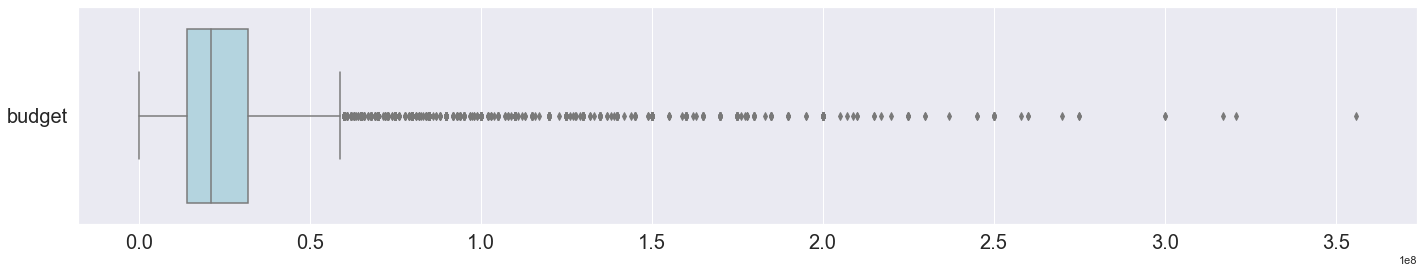

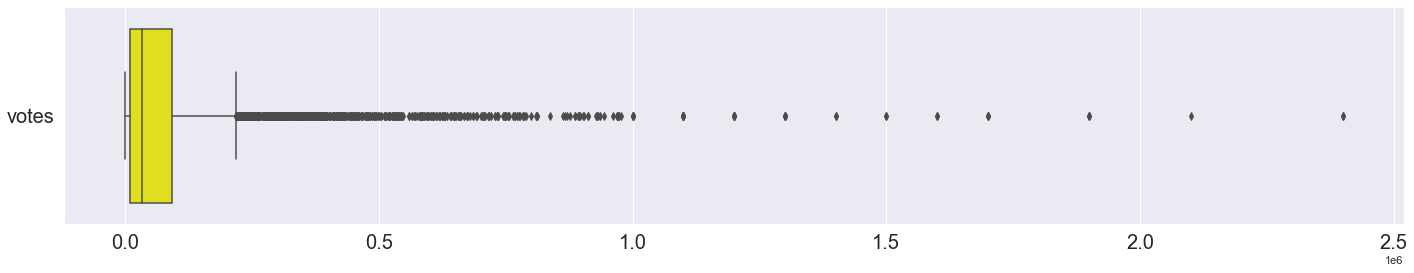

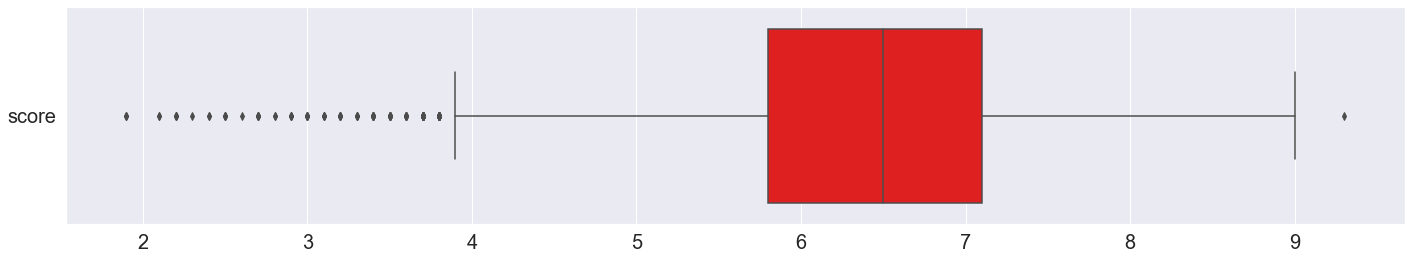

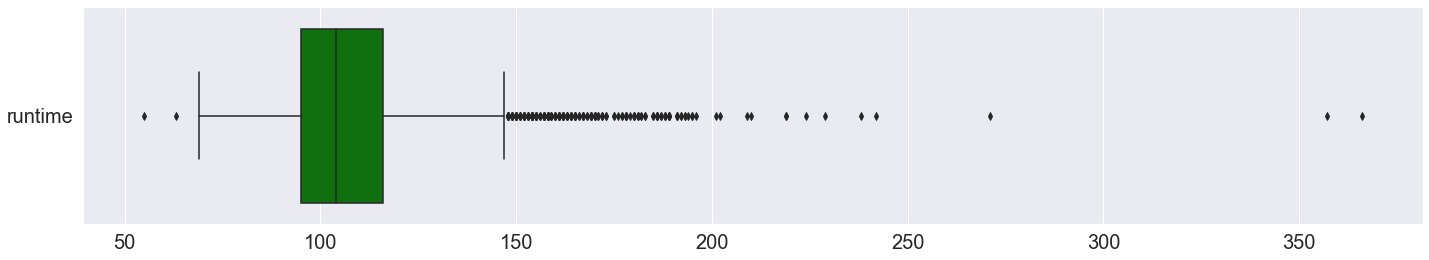

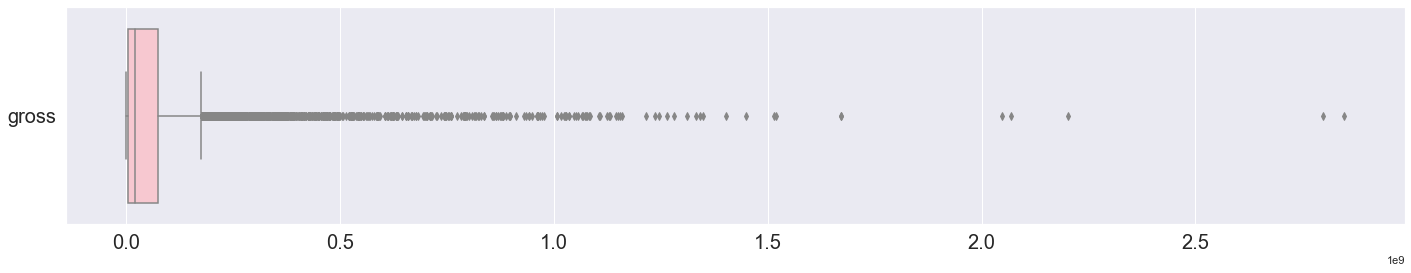

In [19]:
#boxplot for budget
plt.figure(figsize=(24, 4))
plt.xticks(fontsize= 20)
plt.yticks(fontsize = 20)
sns.boxplot(data = budget, orient = "h", color="lightblue")

#boxplot for votes
plt.figure(figsize=(24, 4))
plt.xticks(fontsize= 20)
plt.yticks(fontsize = 20)
sns.boxplot(data = votes, orient = "h", color="yellow")

#boxplot for score
plt.figure(figsize=(24, 4))
plt.xticks(fontsize= 20)
plt.yticks(fontsize = 20)
sns.boxplot(data = score, orient = "h",color="red")

#boxplot for runtime
plt.figure(figsize=(24, 4))
plt.xticks(fontsize= 20)
plt.yticks(fontsize = 20)
sns.boxplot(data = runtime , orient = "h", color="green")

#boxplot for gross
plt.figure(figsize=(24, 4))
plt.xticks(fontsize= 20)
plt.yticks(fontsize = 20)
sns.boxplot(data = gross, orient = "h", color="pink")

From the box plots, it seems like `votes`, `budget`, `gross` and `runtime` are heavily right-skewed as there are many outliers above the upper bound limit.
<br>
<br>
<br>
<br>
We might have to apply some transformation on these variables later on, but let us continue with our analysis.

## Categorical Variables


We will be looking at `Director`, `Writer`, `Star`, `Year`, `Released`, `Country`, `Rating`, `Company`, `Genre`

### Uni-Variate Analysis

#### Movie Name

(-0.5, 1599.5, 799.5, -0.5)

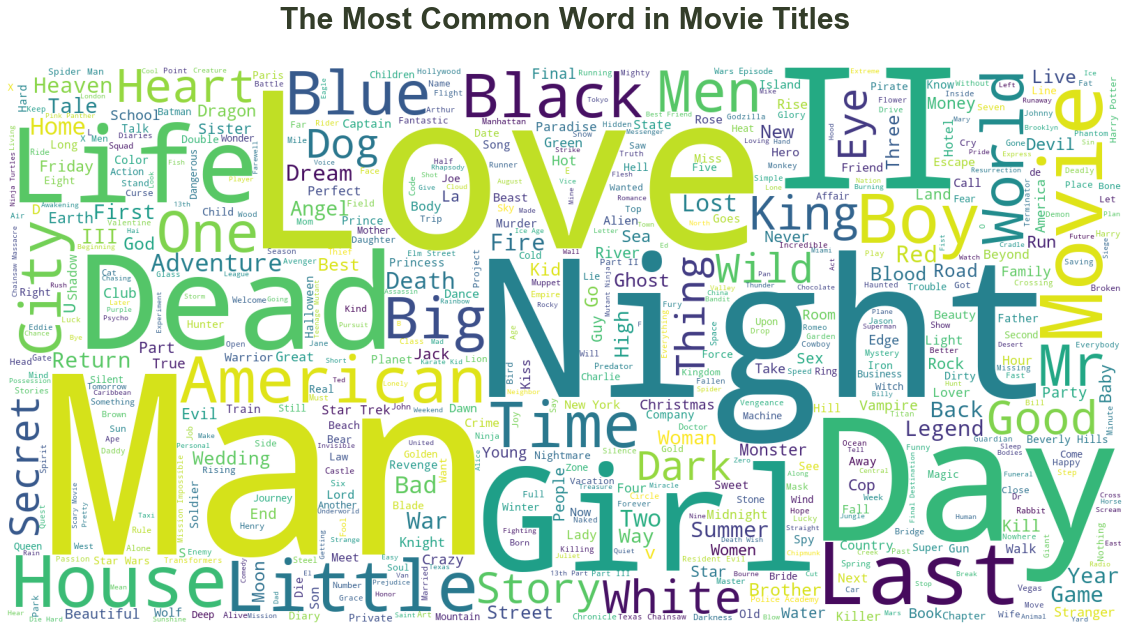

In [20]:
plt.figure(figsize=(20,20))
plt.title('The Most Common Word in Movie Titles\n', fontsize=30, weight=600, color='#333d29')
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white").generate(' '.join(data['name']))

plt.imshow(wc)
plt.axis("off")

* "Love", "Man", "Night", "Day" - These are the most common words in movie titles and they are bound to remind everyone of their favourite movies.

#### Top Film Crew

Here we will look at the number of movies produced by each of these four categories: `Companies`

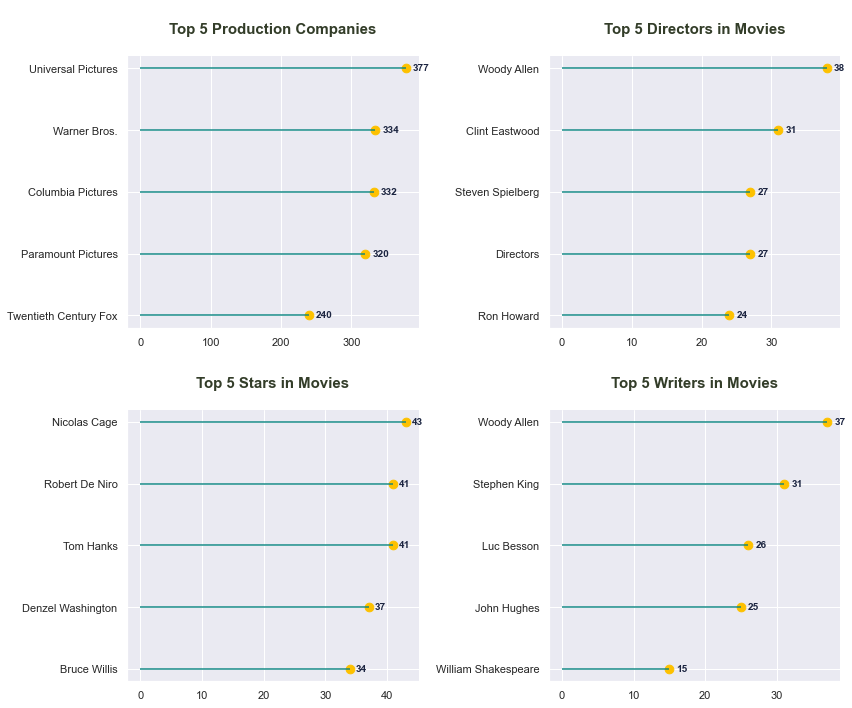

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
# Company plot
# Creating a new dataframe that only includes top 10 Companies
top_5_company = pd.DataFrame(data["company"].value_counts().head(5)).sort_values(by='company', ascending=True)
axes[0,0].hlines(y=top_5_company.index, xmin=0, xmax=top_5_company["company"], color= '#06837f', alpha=0.7, linewidth=2)
axes[0,0].scatter(x=top_5_company["company"], y=top_5_company.index, s = 75, color='#fdc100')
axes[0,0].set_title('\nTop 5 Production Companies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(top_5_company["company"]):
    axes[0,0].text(value+10, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Director plot
top_5_director = pd.DataFrame(data["director"].value_counts().head(5)).sort_values(by='director', ascending=True)
axes[0,1].hlines(y=top_5_director.index, xmin=0, xmax=top_5_director["director"], color= '#06837f', alpha=0.7, linewidth=2)
axes[0,1].scatter(x=top_5_director["director"], y=top_5_director.index, s = 75, color='#fdc100')
axes[0,1].set_title('\nTop 5 Directors in Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(top_5_director["director"]):
    axes[0,1].text(value+1, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Star plot
top_5_star = pd.DataFrame(data["star"].value_counts().head(5)).sort_values(by='star', ascending=True)
axes[1,0].hlines(y=top_5_star.index, xmin=0, xmax=top_5_star['star'], color= '#06837f', alpha=0.7, linewidth=2)
axes[1,0].scatter(x=top_5_star['star'], y=top_5_star.index, s = 75, color='#fdc100')
axes[1,0].set_title('\nTop 5 Stars in Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(top_5_star['star']):
    axes[1,0].text(value+1, i, value, va='center', fontsize=10, weight=600, color='#1c2541')
    
# Writer plot
top_5_writer = pd.DataFrame(data["writer"].value_counts().head(5)).sort_values(by='writer', ascending=True)
axes[1,1].hlines(y=top_5_writer.index, xmin=0, xmax=top_5_writer['writer'], color= '#06837f', alpha=0.7, linewidth=2)
axes[1,1].scatter(x=top_5_writer['writer'], y=top_5_writer.index, s = 75, color='#fdc100')
axes[1,1].set_title('\nTop 5 Writers in Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(top_5_writer['writer']):
    axes[1,1].text(value+1, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

sns.despine()
plt.tight_layout()

* Universal Pictures is the largest production company with 377 movies produced

* Woody Allen leads both directors and writers in movies produced

* The Top 5 Lists are mostly dominated by American presence, we will likely expect most films to be American

#### Countries 

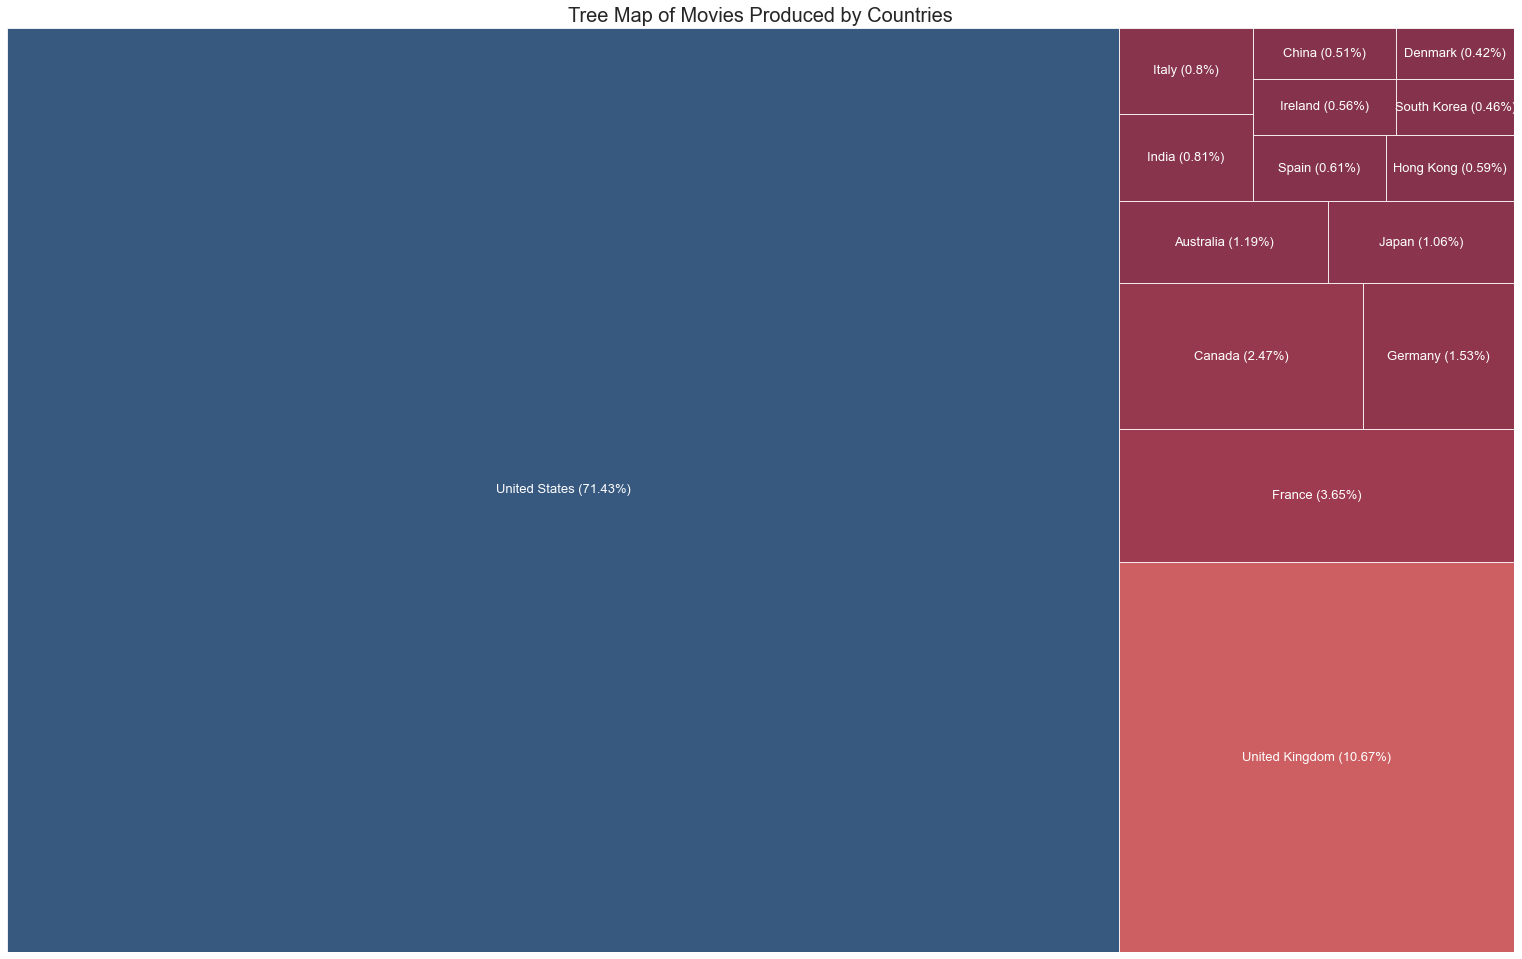

In [22]:
plt.figure(figsize=(27,17))
plt.title("Tree Map of Movies Produced by Countries", fontsize = 20)
plt.axis('off')

countries_count = pd.DataFrame(data["country"].value_counts())
countries_count["label"] = countries_count.index + " (" + round(100 * countries_count["country"] / sum(countries_count["country"]), 2).astype("str") + "%)"
countries_count_top_15 = countries_count.head(15)

# create a color palette, mapped to country counts
cmap = matplotlib.cm.RdBu
mini=min(countries_count_top_15["country"])
maxi=max(countries_count_top_15["country"])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(count)) for count in countries_count_top_15["country"]]
 
# Create plot
squarify.plot(sizes=countries_count_top_15["country"], label=countries_count_top_15["label"], color = colors, text_kwargs={'fontsize':13,'color' :'w'},alpha=0.8)
plt.show()

* As expected, the US dominates the movies industry, with 71.4% of movies coming from the US.

#### Genre

Number of Genres : 19
Comedy       2243
Action       1700
Drama        1509
Crime         550
Biography     442
Adventure     426
Animation     338
Horror        321
Fantasy        44
Mystery        20
Name: genre, dtype: int64


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Comedy'),
  Text(0, 1, 'Action'),
  Text(0, 2, 'Drama'),
  Text(0, 3, 'Crime'),
  Text(0, 4, 'Biography'),
  Text(0, 5, 'Adventure'),
  Text(0, 6, 'Animation'),
  Text(0, 7, 'Horror'),
  Text(0, 8, 'Fantasy'),
  Text(0, 9, 'Mystery')])

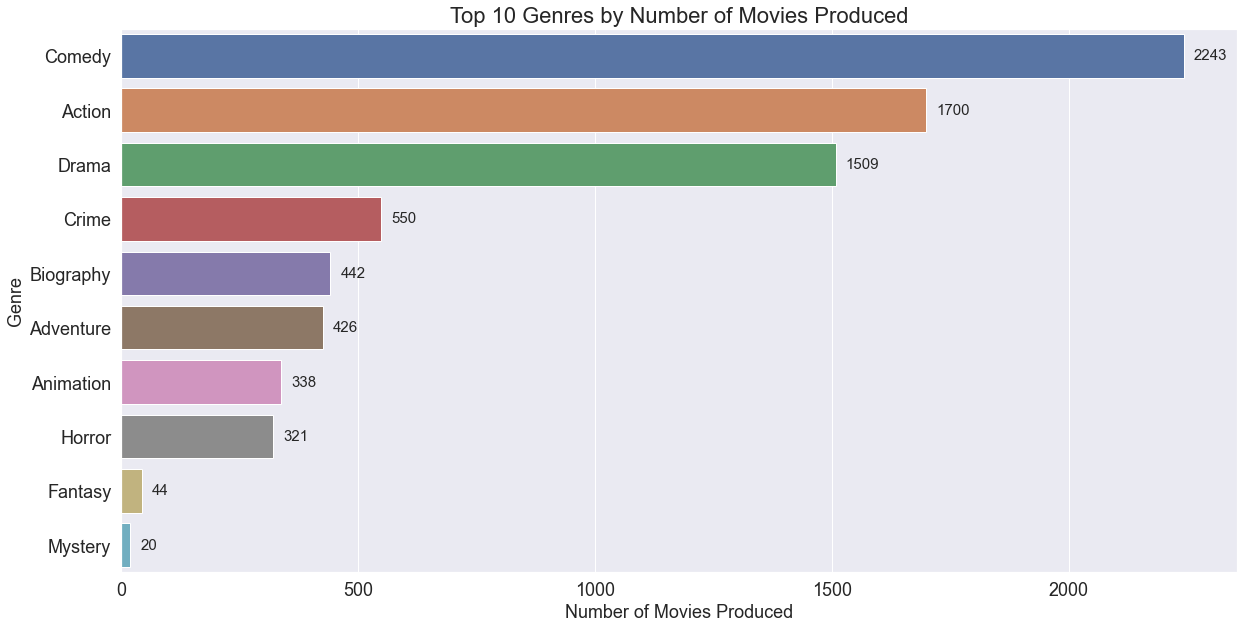

In [23]:
# Genres in the Dataset
print("Number of Genres :", len(data["genre"].unique()))

# Movies from each genre
print(data["genre"].value_counts().head(10))

# Count plot showing number of Top 10 movie genres
plt.figure(figsize = (20,10))
s = sns.countplot(y="genre", data=data, order=data["genre"].value_counts().head(10).index)

s.bar_label(container=s.containers[0], labels=data["genre"].value_counts().head(10).values,padding=10, fontsize = 15)
s.set_xlabel("Number of Movies Produced", fontsize = 18)
s.set_ylabel("Genre", fontsize = 18)
s.set_title("Top 10 Genres by Number of Movies Produced", fontsize = 22)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

* It seems like the genre of Comedy is very popular as it has a significant lead on the industry in movies produced

#### Rating

Number of Movie Ratings Category : 12
R            3688
PG-13        2111
PG           1248
Not Rated     355
G             153
Unrated        51
NC-17          23
TV-MA           9
TV-PG           5
X               3
Name: rating, dtype: int64


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'R'),
  Text(0, 1, 'PG-13'),
  Text(0, 2, 'PG'),
  Text(0, 3, 'Not Rated'),
  Text(0, 4, 'G'),
  Text(0, 5, 'Unrated'),
  Text(0, 6, 'NC-17'),
  Text(0, 7, 'TV-MA'),
  Text(0, 8, 'TV-PG'),
  Text(0, 9, 'X')])

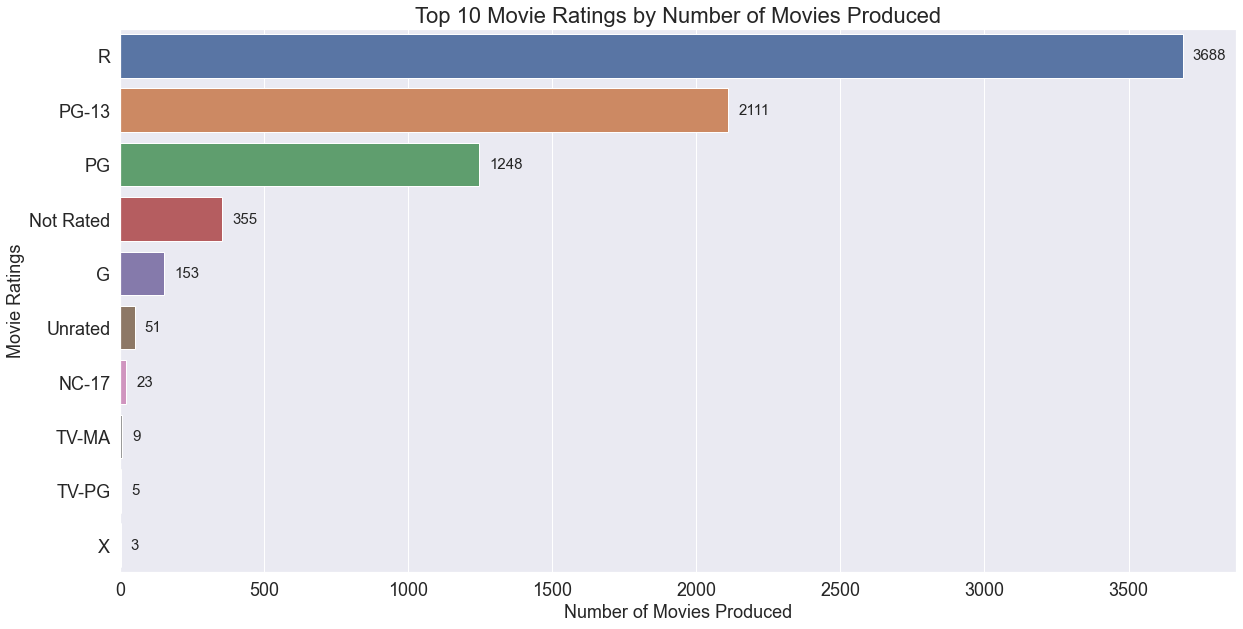

In [24]:
# Ratings in the Dataset
print("Number of Movie Ratings Category :", len(data["rating"].unique()))

# Movies from each rating
print(data["rating"].value_counts().head(10))

# Count plot showing number of Top 10 movie ratings
plt.figure(figsize = (20,10))
s = sns.countplot(y="rating", data=data, order=data["rating"].value_counts().head(10).index)

s.bar_label(container=s.containers[0], labels=data["rating"].value_counts().head(10).values,padding=10, fontsize = 15)
s.set_xlabel("Number of Movies Produced", fontsize = 18)
s.set_ylabel("Movie Ratings", fontsize = 18)
s.set_title("Top 10 Movie Ratings by Number of Movies Produced", fontsize = 22)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

* R-Rated movies are the most common, followed by PG-13 and PG

* These 3 Ratings alone accounts for over 90% of the movies

* Movie Producers tend to avoid making movies not in these 3 popular ratings 

## Bi-Variate Analysis

### Pair plot

We will be plotting all the numeric variables against each other to visualise their relationship

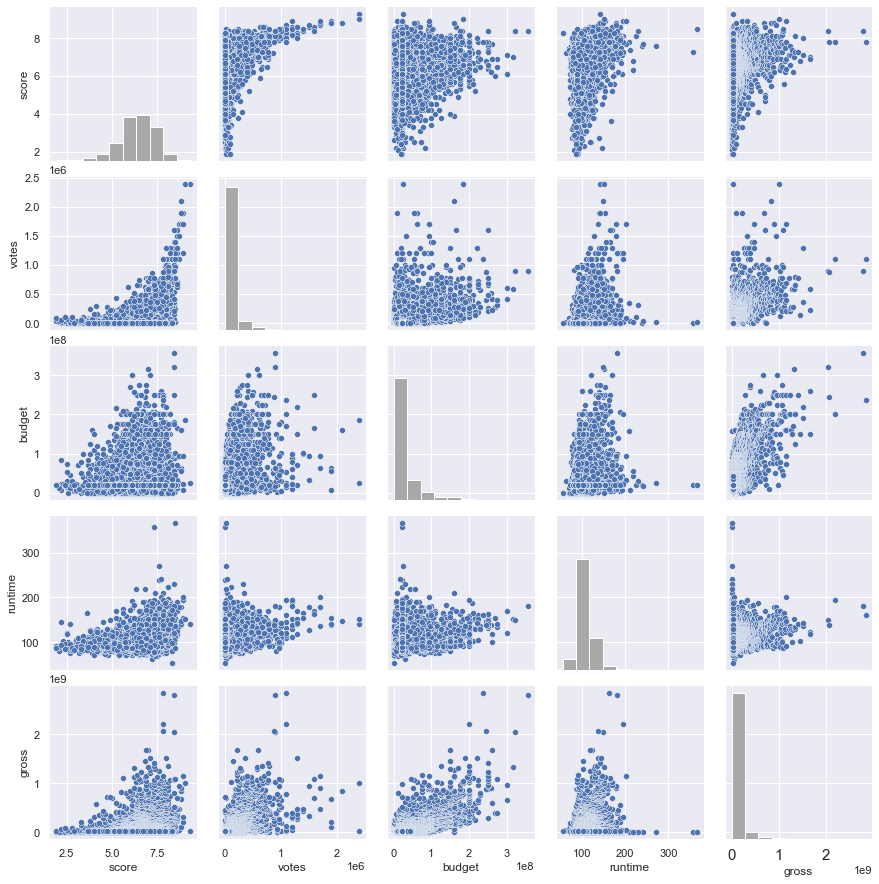

In [25]:
#pair plot to show relationship
g = sns.PairGrid(data[num_var])
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
g.map_diag(plt.hist,color = "darkgrey")
g.map_offdiag(sns.scatterplot)

* Our variables mostly show heavy right skewness
* `score` seems to have a polynomial relationship with `gross`
* Generally the numeric variables have strong linear correlation with `gross`

### Top 5 Genres
We will now analyse the top 5 genres with relation to other varaibles

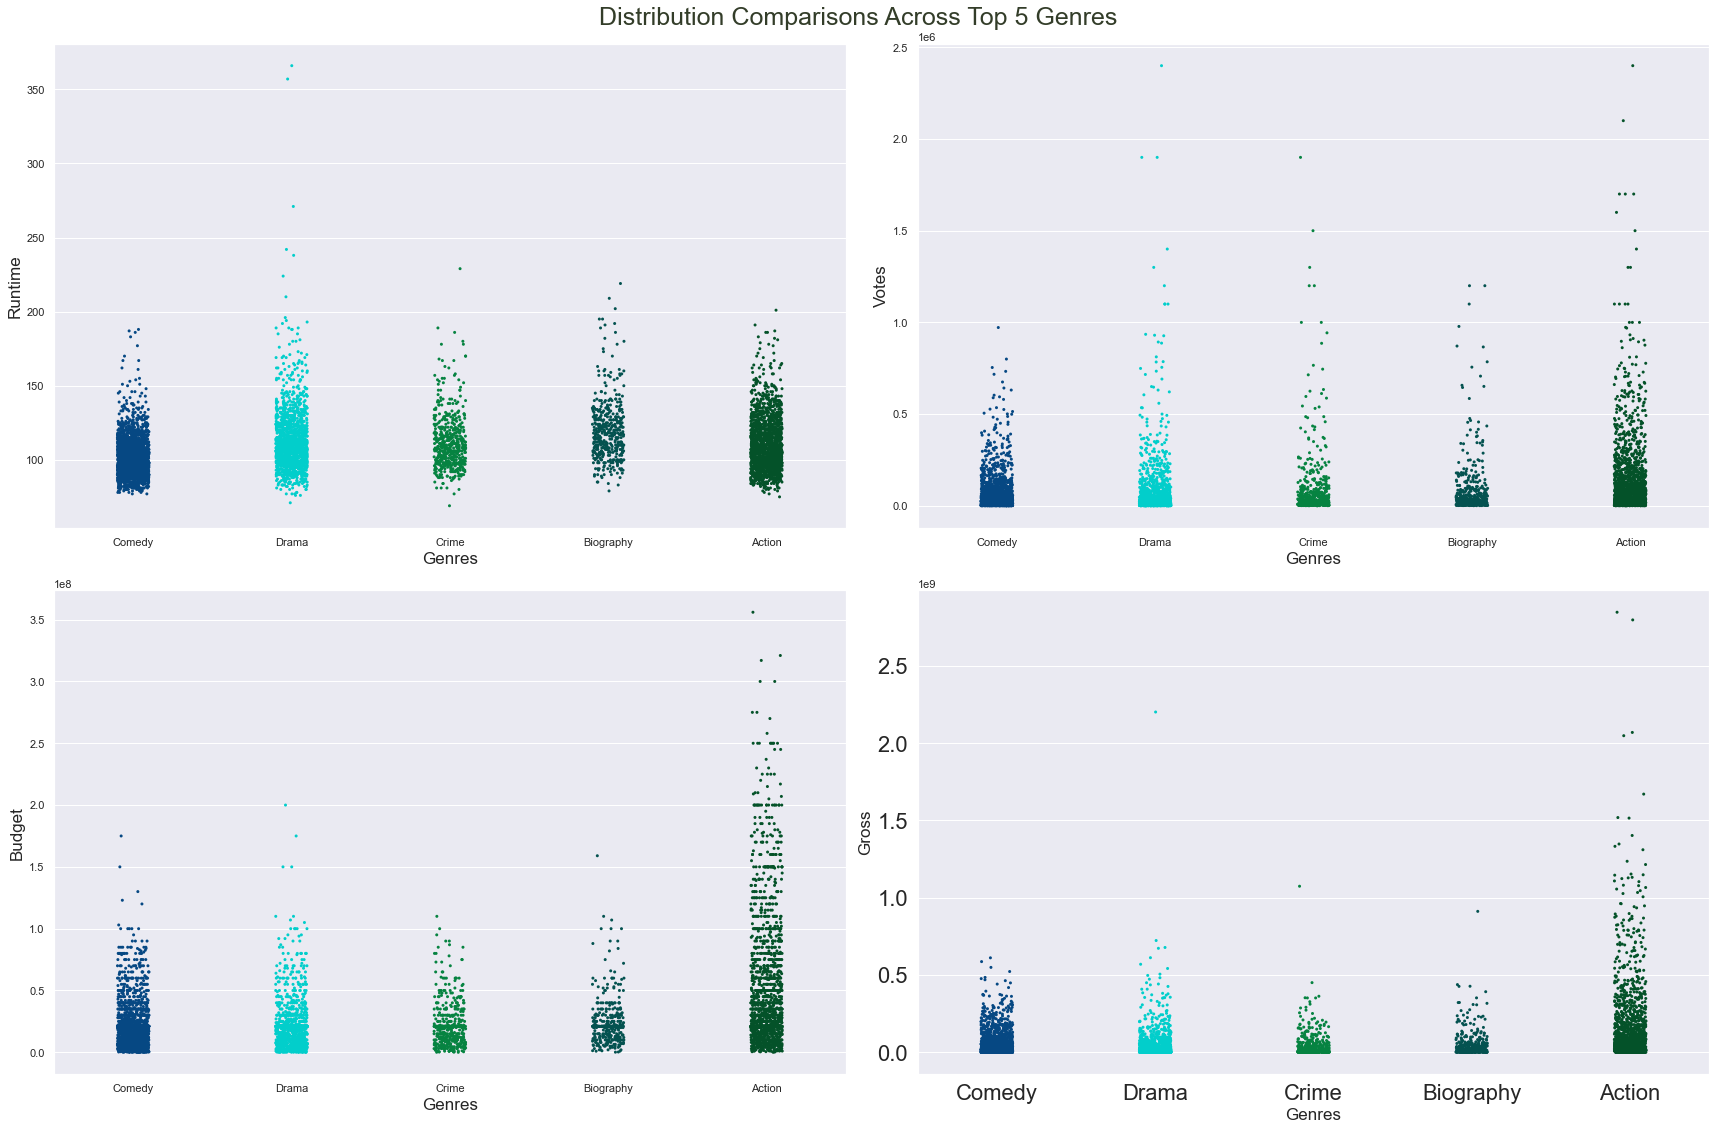

In [26]:
# Creating a new dataframe that only includes top 5 genres
top_5_genre = pd.DataFrame(data["genre"].value_counts().head(5))
top_5_genre_data = data[data["genre"].isin(top_5_genre["genre"].index.values)]

# Creating a Strip Plot to compare the distribution of runtime, votes, budget and gross broken down into the top 5 genres
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,16))
plt.tick_params(axis='both', which='major', labelsize=22)

# Plot against each variable
plt.suptitle('Distribution Comparisons Across Top 5 Genres', fontsize=25, color='#333d29')
for i, y in enumerate(['runtime', 'votes', 'budget', 'gross']):
    s = sns.stripplot(data=top_5_genre_data, x='genre', y=y, ax=axes.flatten()[i], palette=['#064883', '#02cecb', '#068341', '#045250', '#045229'], size = 3)
    s.set_xlabel("Genres",fontsize=17) # Set x label and size
    s.set_ylabel(y.title(),fontsize=17) # Set y label and size

plt.tight_layout()

From the strip plot we can see that :

* `Action` genre is the most popular genre of all
  
* The longest films in the top 5 genres belong to `Drama`

* `Action` films boast higher `budget` and `gross` than other genres in the top 5
  
* `Action` and `Drama` films seem to get more `votes` from fans

## Deeper Analysis of Prominent Variables 
We will be diving into the detailed exploratory analysis of our top 3 numeric predictors

### Correlation Plot
We shall take a look at the correlation plot to find out the predictors with the most prominent correlation values.

<AxesSubplot:>

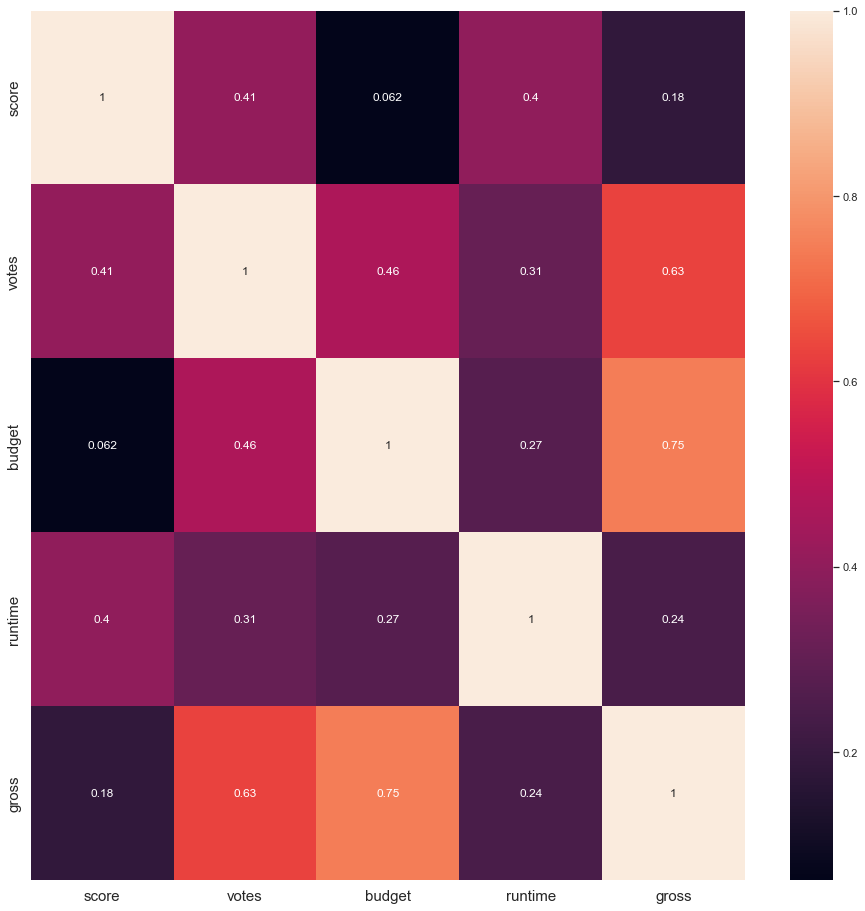

In [27]:
# Correlation plot to show correlation coefficient
plt.figure(figsize = (16, 16))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
sns.heatmap(data[num_var].corr(), annot = True)

We see that `budget`, `votes` and `runtime` are the most prominent predictors that affects the response: `gross`

<br>

We will be diving into the detailed exploratory analysis of our top 3 numeric predictors:
* `budget`
* `votes`
* `runtime`

### Scatter Plots
We will be comparing each variable of `budget`, `votes` and `runtime` against `gross`.

#### Relationship between `gross` and `budget`.

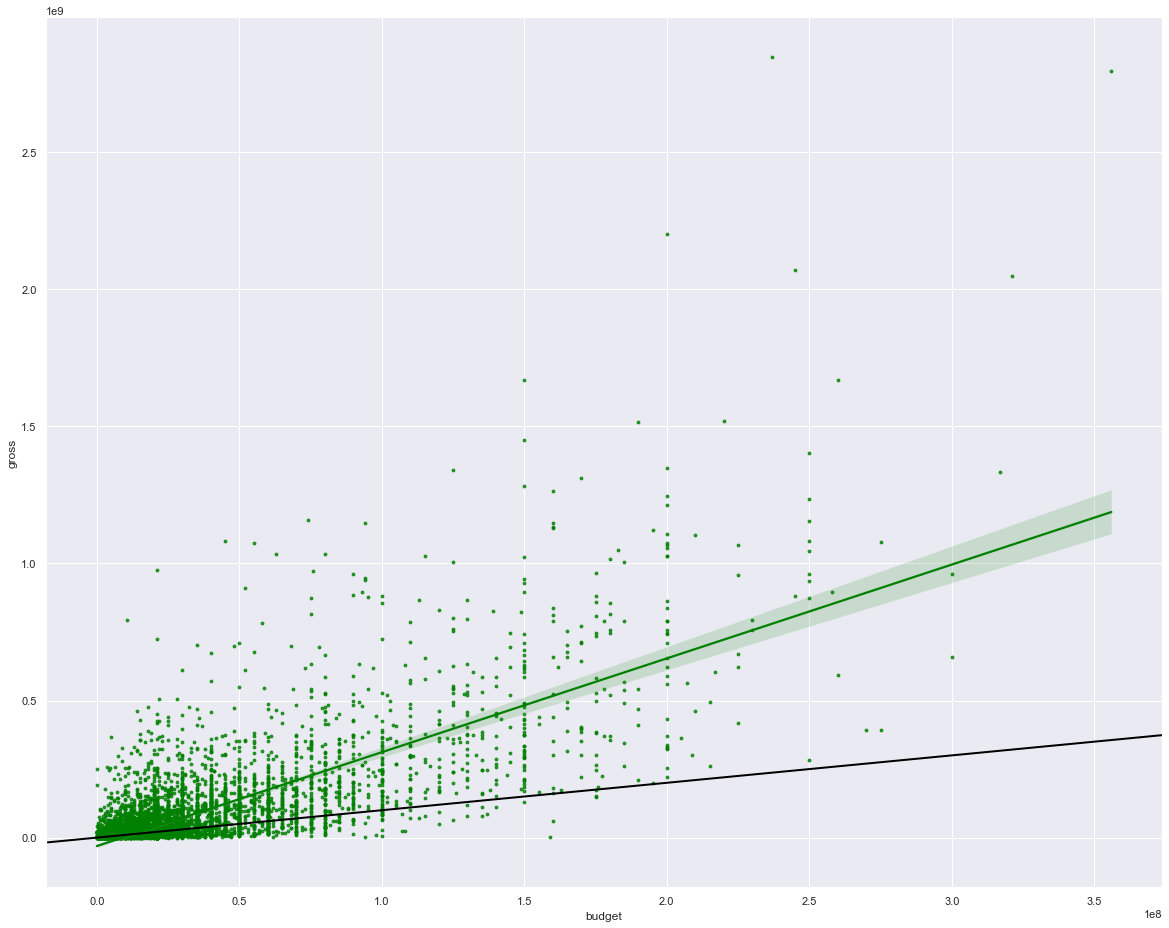

In [28]:
# Scatter plot for gross and budget
fig, ax = plt.subplots(figsize=(20,16))
sns.regplot(x = 'budget', y = 'gross', color = 'green', data = data,scatter_kws = {'s':8})
ax.axline((1,1), slope=1, color='black', lw = 2) # Data points above this line means movie is profitable (Gross Revenue = Budget)
plt.show()

We can see that a majority of the movies are above the black line, which indicates that most movies are profitable as they have higher `gross` than `budget`

#### Relationship between `gross` and `votes`.

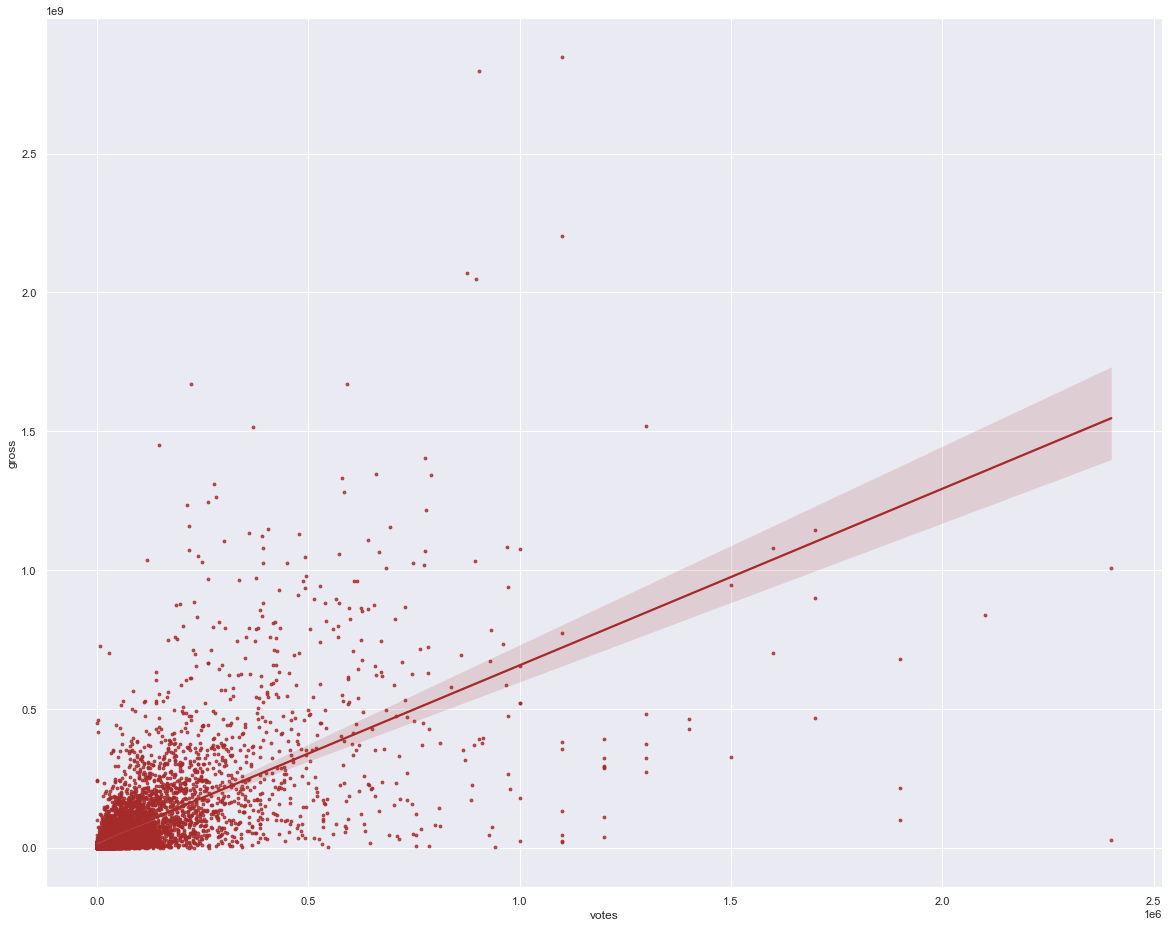

In [29]:
# Scatter plot for gross and votes
fig, ax = plt.subplots(figsize=(20,16))
sns.regplot(x = 'votes', y = 'gross', color = 'brown', data = data,scatter_kws = {'s':8})
plt.show()

* The datapoints seem very clustered around the origin, showing us that most movies receive less than 500,000 `votes`, with `gross` below US$500,000,000

#### Relationship between `gross` and `runtime`.

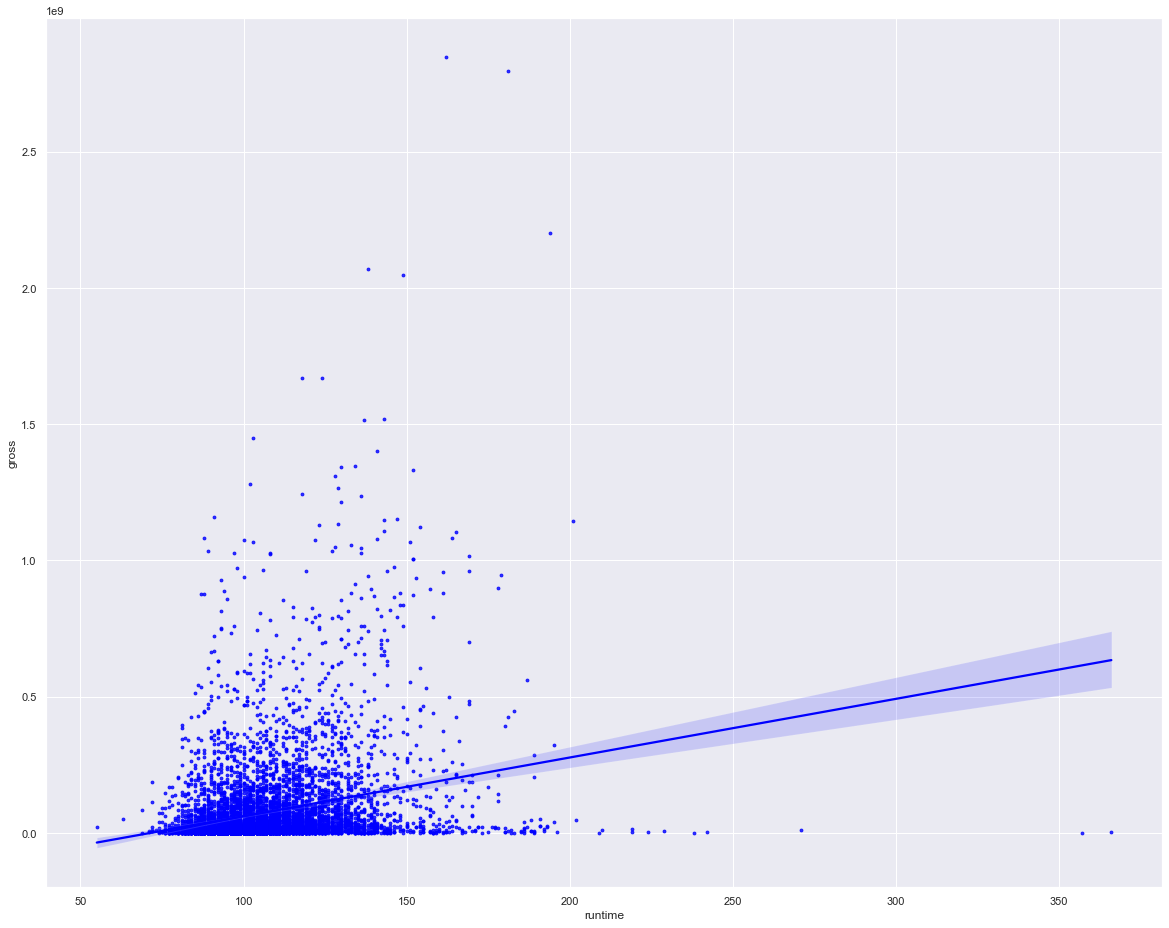

In [30]:
# Scatter plot for gross and runtime
fig, ax = plt.subplots(figsize=(20,16))
sns.regplot(x = 'runtime', y = 'gross', color = 'blue', data = data,scatter_kws = {'s':8})
plt.show()

* This graph is interesting, as the cluster is relatively flatter
* This means that the linear relationship between `gross` and `runtime` is a weaker one and increasing `runtime` is less likely to increase `gross`

# Feature Engineering

## Correcting skewness for numeric variables

### Skewness of Top 3 Correlated Numeric Variables
**Our top 3 correlated variables are `budget`, `votes` and `runtime`.**

Looking at their distribution, these variables are heavily right-skewed and have non-negative values, so we can perform log transformation on them.
<br>
<br>

*Red color plot is **before** correcting skewness*

*Blue color plot is **after** correcting skewness*

#### Skewness of Budget

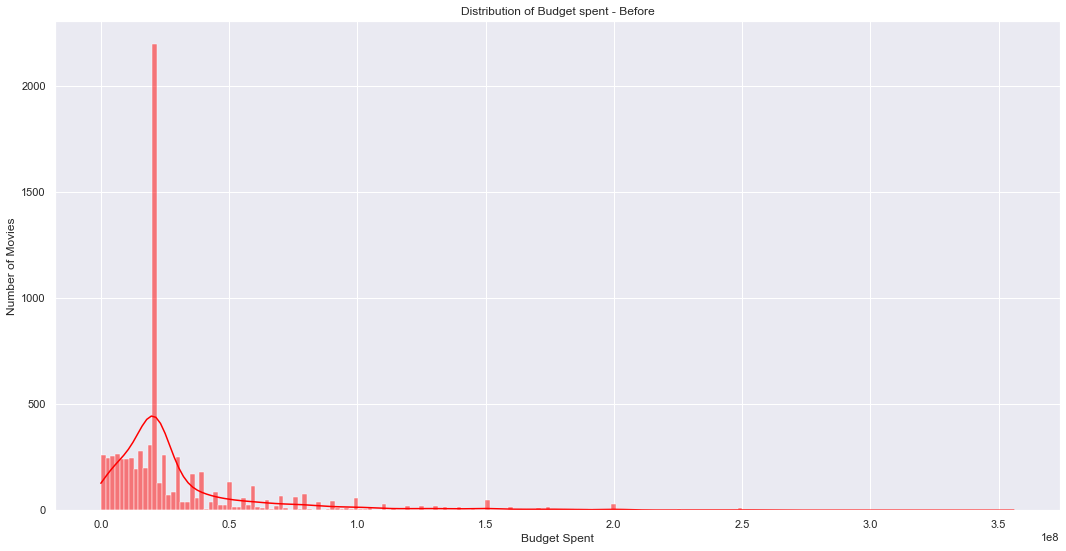

In [31]:
# Histogram for budget before adjusting skewness
f, ax = plt.subplots(figsize=(18,9))
sns.histplot(data['budget'], color="red",kde = True)
ax.set(ylabel="Number of Movies")
ax.set(xlabel="Budget Spent")
ax.set(title="Distribution of Budget spent - Before")
plt.show()

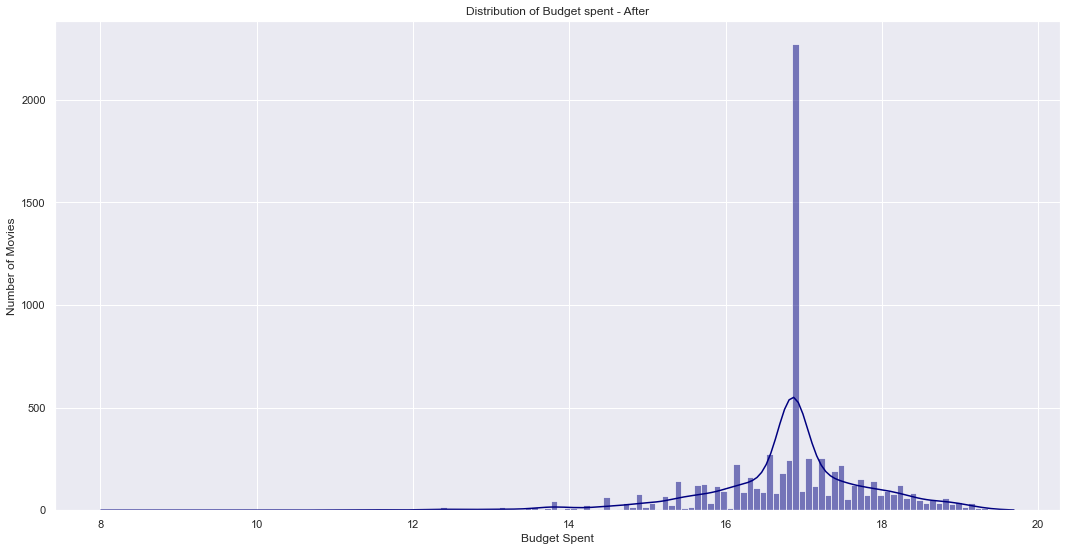

In [32]:
# Applying log transform to correct skewness of budget
data['budget'] = np.log1p(data['budget'])

f, ax = plt.subplots(figsize=(18,9))
sns.histplot(data['budget'], color="navy",kde = True)
ax.set(ylabel="Number of Movies")
ax.set(xlabel="Budget Spent")
ax.set(title="Distribution of Budget spent - After")
plt.show()

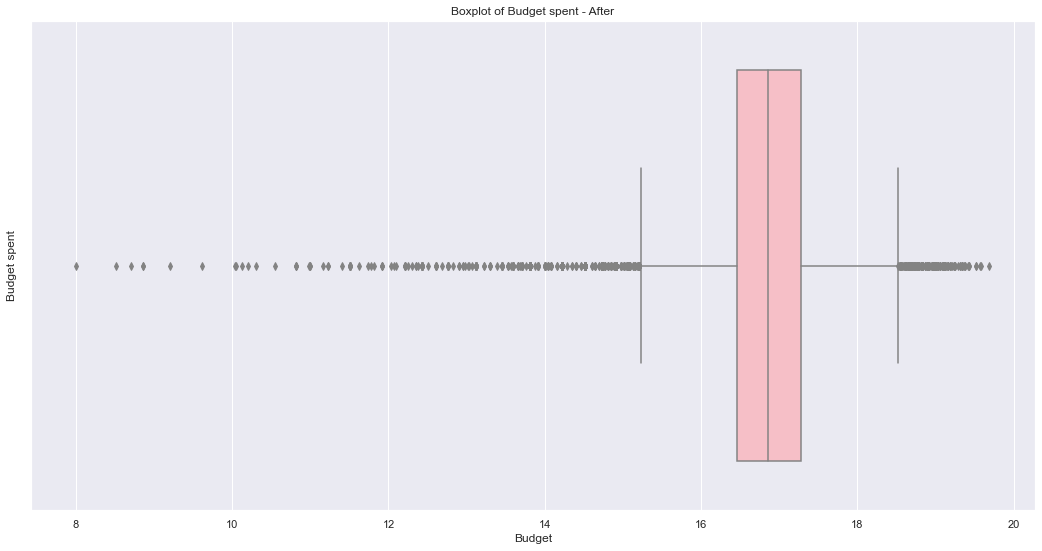

In [33]:
# Boxplot for budget after adjusting skewness
f, ax = plt.subplots(figsize=(18,9))
sns.boxplot(data['budget'], color="lightpink", orient = "h")
ax.set(ylabel="Budget spent")
ax.set(xlabel="Budget")
ax.set(title="Boxplot of Budget spent - After")
plt.show()

* The distribution is more normalised now, but we still have many outliers that cannot be removed as they will impact our training and predictions greatly

#### Skewness of Votes

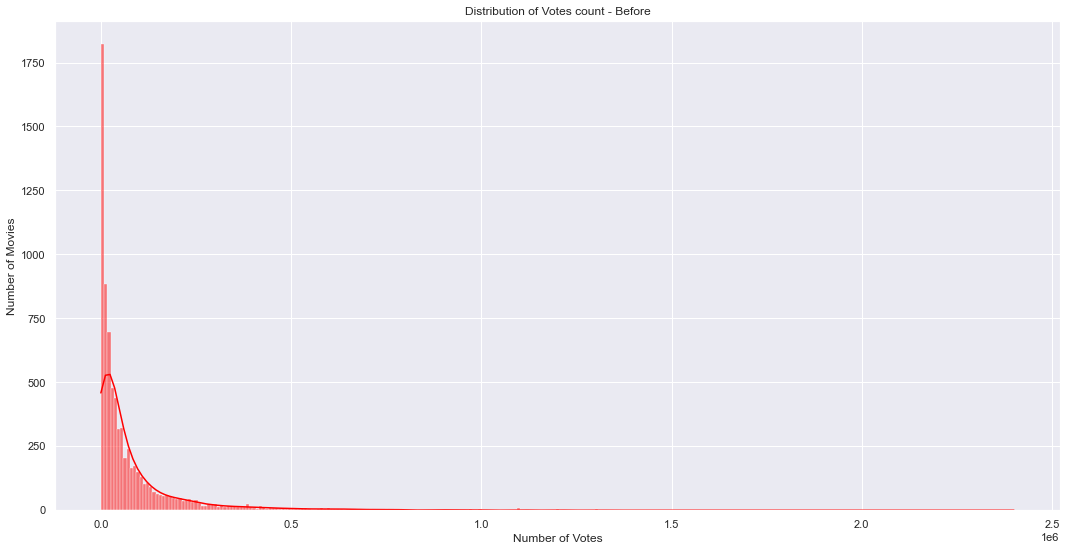

In [34]:
# Histogram for votes before adjusting skewness
f, ax = plt.subplots(figsize=(18,9))
sns.histplot(data['votes'], color="red",kde = True)
ax.set(ylabel="Number of Movies")
ax.set(xlabel="Number of Votes")
ax.set(title="Distribution of Votes count - Before")
plt.show()

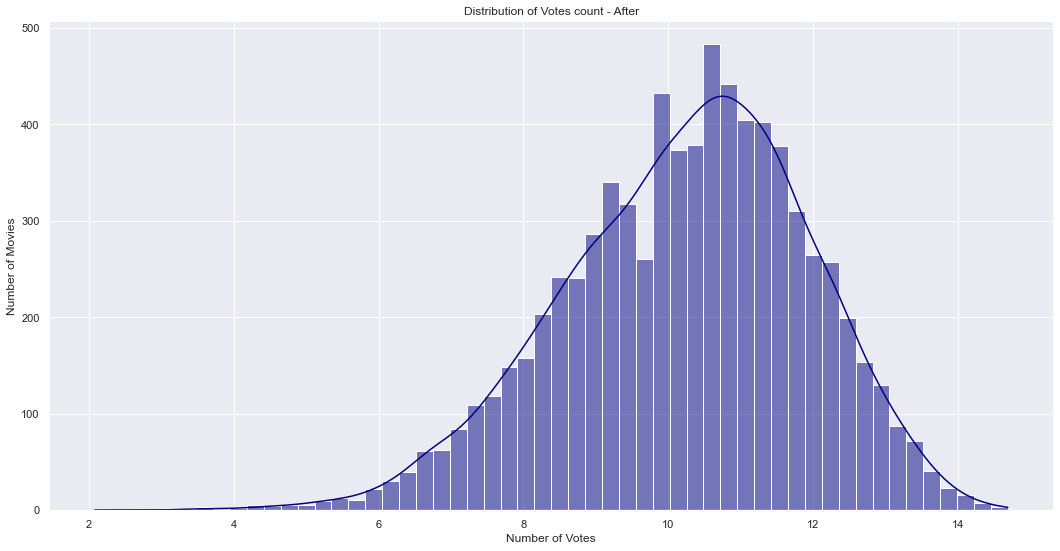

In [35]:
# Applying log transform to correct skewness of votes
data['votes'] = np.log1p(data['votes'])

f, ax = plt.subplots(figsize=(18,9))
sns.histplot(data['votes'], color="navy",kde = True)
ax.set(ylabel="Number of Movies")
ax.set(xlabel="Number of Votes")
ax.set(title="Distribution of Votes count - After")
plt.show()

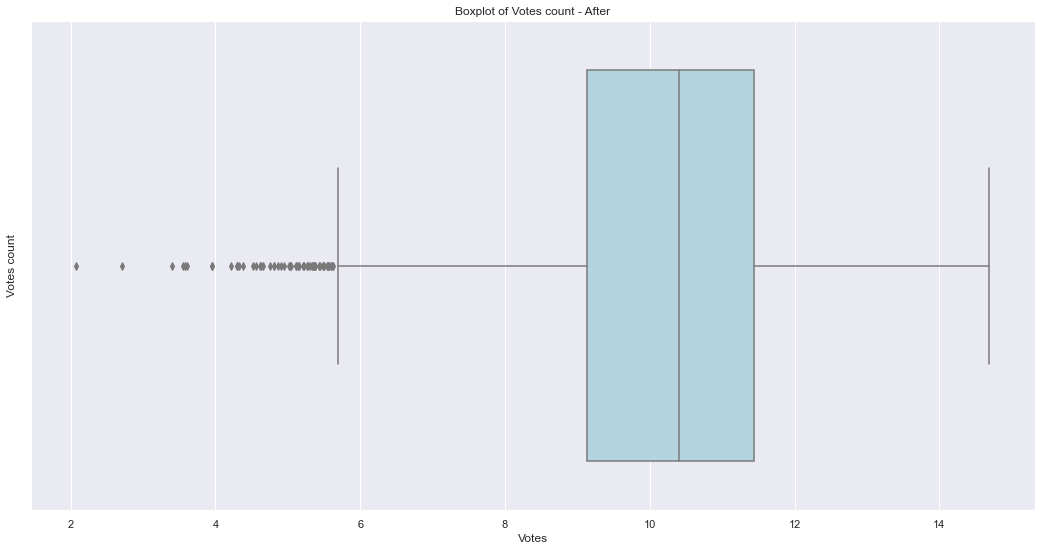

In [36]:
# Boxplot for votes after adjusting skewness
f, ax = plt.subplots(figsize=(18,9))
sns.boxplot(data['votes'], color="lightblue", orient = "h")
ax.set(ylabel="Votes count")
ax.set(xlabel="Votes")
ax.set(title="Boxplot of Votes count - After")
plt.show()

* After log transformation, there are less anomalies in `votes`

#### Skewness of Runtime

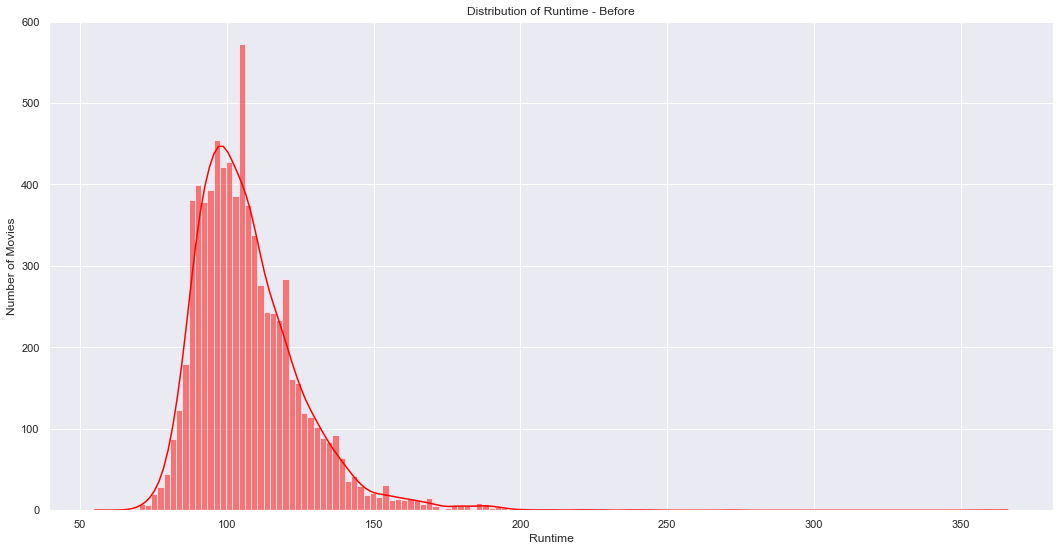

In [37]:
# Histogram for runtime before adjusting skewness
f, ax = plt.subplots(figsize=(18,9))
sns.histplot(data['runtime'], color="red",kde = True)
ax.set(ylabel="Number of Movies")
ax.set(xlabel="Runtime")
ax.set(title="Distribution of Runtime - Before")
plt.show()

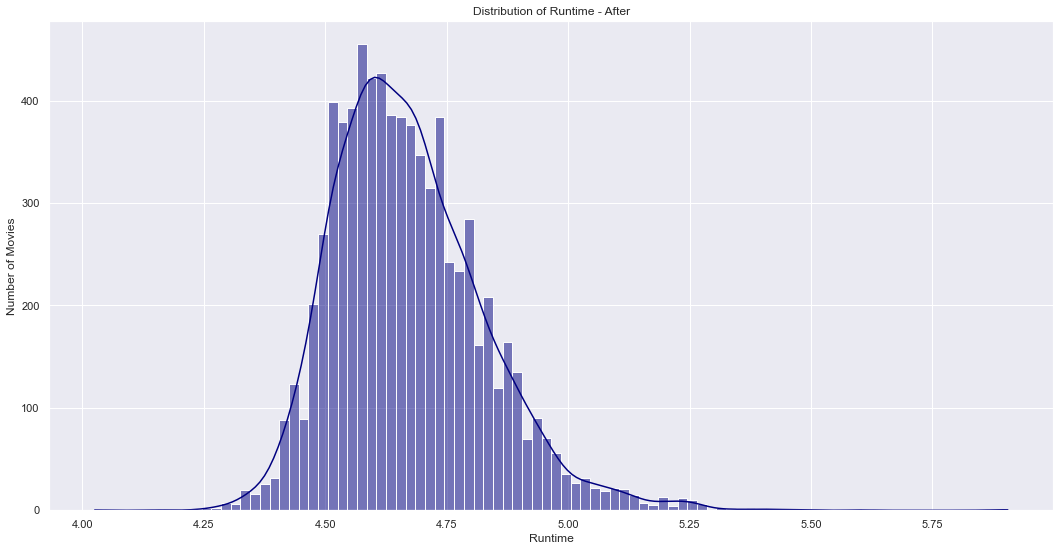

In [38]:
# Applying log transform to correct skewness of runtime
data['runtime'] = np.log1p(data['runtime'])

f, ax = plt.subplots(figsize=(18,9))
sns.histplot(data['runtime'], color="navy",kde = True)
ax.set(ylabel="Number of Movies")
ax.set(xlabel="Runtime")
ax.set(title="Distribution of Runtime - After")
plt.show()

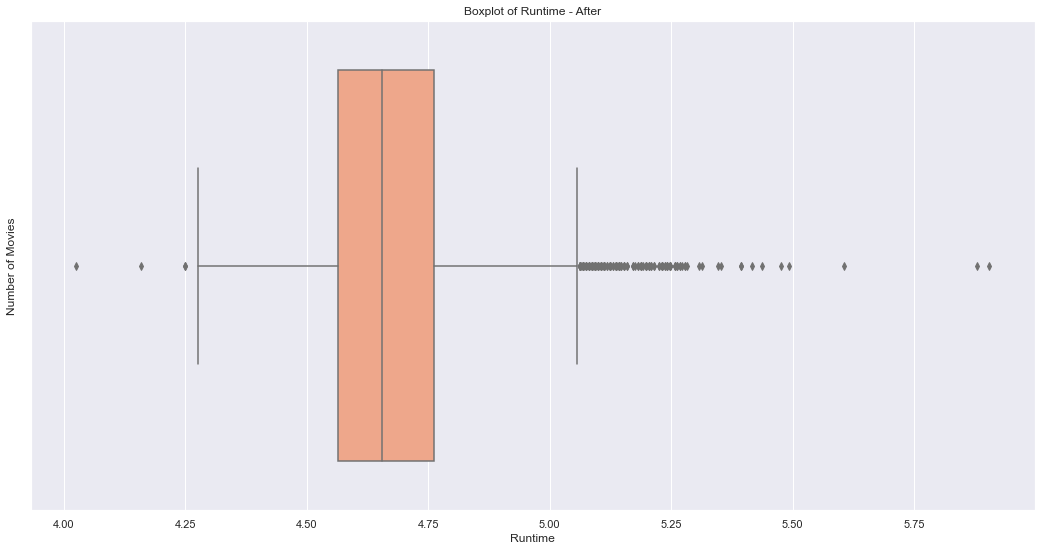

In [39]:
# Boxplot for runtime after adjusting skewness
f, ax = plt.subplots(figsize=(18,9))
sns.boxplot(data['runtime'], color="lightsalmon", orient = "h")
ax.set(ylabel="Number of Movies")
ax.set(xlabel="Runtime")
ax.set(title="Boxplot of Runtime - After") 
plt.show()

* After log transforming `runtime`, there are still many outliers that have very long `runtime`

## Correcting skewness for Response Variable
Since the distribution of `gross` is heavily right-skewed, we will have to normalise it as well and we will likewise use log transformation.

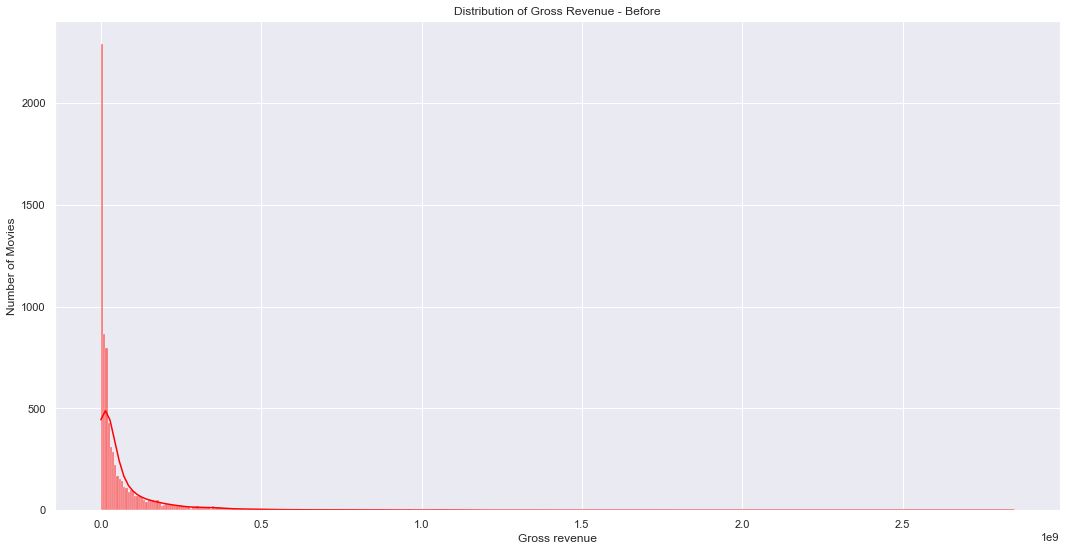

In [40]:
# Histogram for gross before adjusting skewness
f, ax = plt.subplots(figsize=(18,9))
sns.histplot(data['gross'], color="red", kde = True)
ax.set(ylabel="Number of Movies")
ax.set(xlabel="Gross revenue")
ax.set(title="Distribution of Gross Revenue - Before")
plt.show()

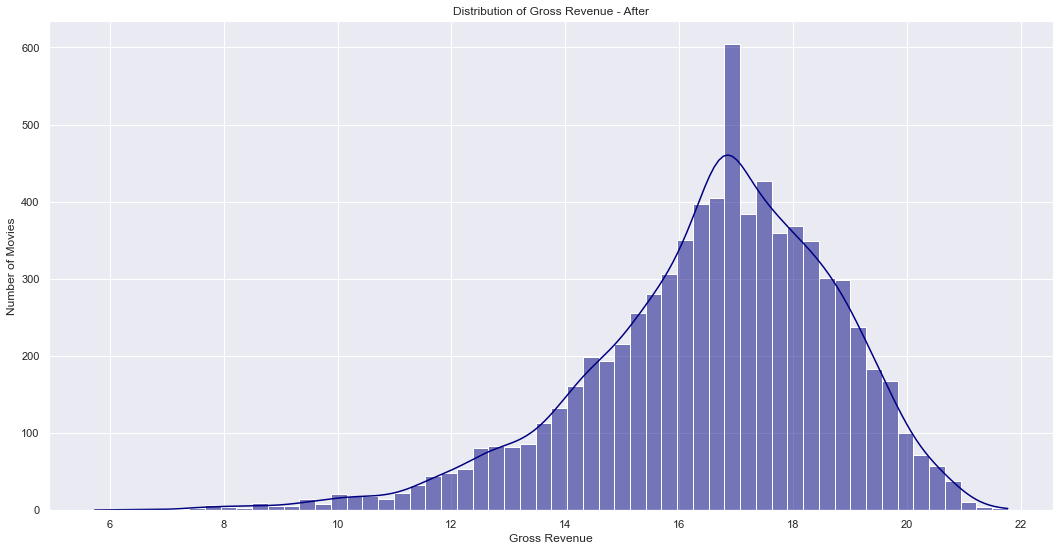

In [41]:
# Applying log transform to correct skewness of gross
data['gross'] = np.log1p(data['gross'])

f, ax = plt.subplots(figsize=(18,9))
sns.histplot(data['gross'], color="navy",kde = True)
ax.set(ylabel="Number of Movies")
ax.set(xlabel="Gross Revenue")
ax.set(title="Distribution of Gross Revenue - After")
plt.show()

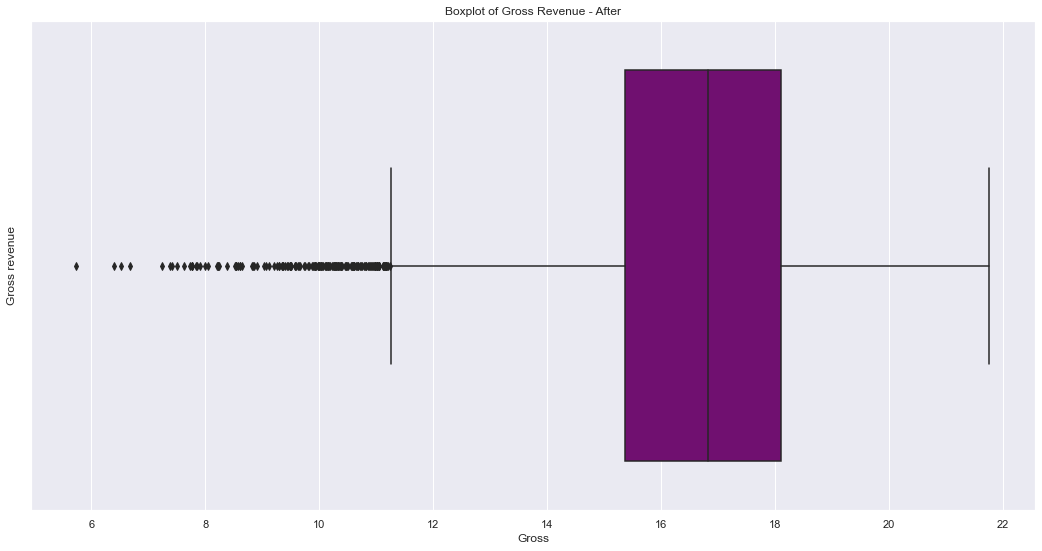

In [42]:
# Boxplot for gross after adjusting skewness
f, ax = plt.subplots(figsize=(18,9))
sns.boxplot(data['gross'], color="purple", orient = "h")
ax.set(ylabel="Gross revenue")
ax.set(xlabel="Gross")
ax.set(title="Boxplot of Gross Revenue - After")
plt.show()

* As expected after studying the original distribution of `gross`, most movies have low gross which explains the anomalies in the lower bound

## Removal of insignificant columns
Columns that do not provide meaningful information when trying to predict the gross revenue of a movie will be removed from the dataset to prevent inaccuracies.

<br>

`released` and `year` will not help with our predictions as we cannot traverse through time, so they will be removed.

In [43]:
data = data.drop(['released','year'],axis = 1)
data.head()

,name,rating,genre,score,votes,director,writer,star,country,budget,company,runtime,gross
0,Trojan War,PG-13,Comedy,5.7,8.665786,George Huang,Andy Burg,Will Friedle,United States,16.523561,Daybreak,4.454347,5.736572
1,Madadayo,Not Rated,Drama,7.3,8.537192,Akira Kurosawa,Ishirô Honda,Tatsuo Matsumura,Japan,16.292049,DENTSU Music And Entertainment,4.905275,6.391917
2,Run with the Hunted,Not Rated,Crime,5.2,6.601230,John Swab,John Swab,Ron Perlman,United States,16.860033,Roxwell Films,4.543295,6.526495
3,The Untold Story,Not Rated,Comedy,5.7,5.771441,Shane Stanley,Lee Stanley,Miko Hughes,United States,16.860033,Visual Arts Entertainment,4.653960,6.673298
4,"Love, Honor and Obey",R,Comedy,6.5,8.556606,Dominic Anciano,Dominic Anciano,Sadie Frost,United Kingdom,16.860033,British Broadcasting Corporation (BBC),4.644391,7.244942


## Encoding Categorical Variables

To fit our categorical variables into our models, we would need to convert them into numeric variables through encoding.

We will check the number of unique levels/fields in each categorical variable to determine the type of encoding we can use.

### Checking number of unique fields in each column

In [44]:
data.nunique()

name        7493
rating        12
genre         19
score         72
votes        927
director    2939
writer      4523
star        2808
country       59
budget       411
company     2384
runtime      138
gross       7459
dtype: int64

It seems like we have too many unique fields in our categorical variables, OneHotEncoding might result in us having too many columns

Hence, we will be using OrdinalEncoder to encode our categorical data.

In [45]:
oe = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value=-1)
#categorical variable to be encoded
cat_var_encode = ['director', 'writer', 'rating', 'genre', 'name', 'star', 'country', 'company']
data[cat_var_encode] = oe.fit_transform(data[cat_var_encode])

In [46]:
data[cat_var_encode]
#data are all in numeric 

,director,writer,rating,genre,name,star,country,company
0,959.0,227.0,5.0,4.0,6973.0,2752.0,55.0,821.0
1,33.0,1714.0,3.0,6.0,3399.0,2556.0,27.0,796.0
2,1440.0,2196.0,3.0,5.0,4654.0,2272.0,55.0,1991.0
3,2536.0,2556.0,3.0,4.0,6704.0,1909.0,55.0,2307.0
4,728.0,1119.0,6.0,4.0,3353.0,2313.0,54.0,477.0
...,...,...,...,...,...,...,...,...
7646,614.0,3477.0,3.0,6.0,2060.0,1067.0,54.0,626.0
7647,2209.0,3389.0,4.0,6.0,1509.0,283.0,55.0,189.0
7648,772.0,2605.0,3.0,4.0,1677.0,1880.0,55.0,539.0
7649,2581.0,3979.0,3.0,4.0,337.0,195.0,55.0,83.0


# Building Models
**Models used:**
1. Multiple Linear Regressor
2. Polynomial Regressor
3. LightGBM Regressor
4. Gradient Boosting Regressor
5. Random Forest Regressor
6. XGBoost Regressor

**Evaluation Metrics:**

We judge the performance of our models on Root Mean Squared Error (RMSE) and Mean Absolute Percentage Error (MAPE). 
In this notebook, MAPE is represented by a decimal rather than a percentage.

## Train-Test Split
We will split the dataset into 80-20 ratio

<br>

Predictor: `name`, `rating`, `genre`, `score`, `votes`, `director`, `writer`, `star`, `country`, `budget`, `company`, `runtime`

<br>

Response: `gross`


In [47]:
predictor = pd.DataFrame(data.iloc[:,:-1])
response = pd.DataFrame(data.iloc[:,-1])

In [48]:
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(predictor, response, test_size = 0.2, random_state=1015)

#### Using KFold to perform 5 fold Cross-Validation

In [49]:
kf = KFold(n_splits = 5, shuffle = True, random_state=1015).get_n_splits(data.values)

# Making scorer for Mean Absolute Percentage Error
mape_scorer = make_scorer(mean_absolute_percentage_error)

## Multiple Linear Regression

In [50]:
linear = LinearRegression()

# Use cross_val_score to calculate both RMSE and MAPE
linear_mse_cv_scores = - cross_val_score(linear, X_train,y_train,cv = kf, scoring = 'neg_mean_squared_error',n_jobs = -1)
linear_rmse_cv_scores = np.sqrt(linear_mse_cv_scores)

linear_mape_cv_scores = cross_val_score(linear, X_train, y_train, cv=kf, scoring=mape_scorer)

print('Multiple Linear Regressor CV RMSE Score:', linear_rmse_cv_scores.mean())
print('Multiple Linear Regressor CV MAPE Score:', linear_mape_cv_scores.mean())

Multiple Linear Regressor CV RMSE Score: 1.5113391257008966
Multiple Linear Regressor CV MAPE Score: 0.07133472974606556


## Polynomial Regression

In [51]:
# Make pipeline for polynomial regression using linear regression and polynomial features
def polynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

poly = polynomialRegression(degree = 4)

# Use cross_val_score to calculate both RMSE and MAPE
poly_mse_cv_scores = - cross_val_score(poly,X_train,y_train,cv = kf, scoring = 'neg_mean_squared_error',n_jobs = -1)
poly_rmse_cv_scores = np.sqrt(poly_mse_cv_scores)

poly_mape_cv_scores = cross_val_score(poly, X_train, y_train, cv=kf, scoring=mape_scorer)

print('Polynomial Regressor CV RMSE Score:', poly_rmse_cv_scores.mean())
print('Polynomial Regressor CV MAPE Score:', poly_mape_cv_scores.mean())

Polynomial Regressor CV RMSE Score: 2.4889141678604223
Polynomial Regressor CV MAPE Score: 0.09988866218413839


## LightGBM

In [52]:
lgbm = LGBMRegressor()

# Use cross_val_score to calculate both RMSE and MAPE
lgbm_mse_cv_scores = - cross_val_score(lgbm, X_train,y_train,cv = kf, scoring = 'neg_mean_squared_error',n_jobs = -1)
lgbm_rmse_cv_scores = np.sqrt(lgbm_mse_cv_scores)

lgbm_mape_cv_scores = cross_val_score(lgbm, X_train, y_train, cv=kf, scoring=mape_scorer)

print('LightGBM Regressor CV RMSE Score:', lgbm_rmse_cv_scores.mean())
print('LightGBM Regressor CV MAPE Score:', lgbm_mape_cv_scores.mean())

LightGBM Regressor CV RMSE Score: 1.3464213880614246
LightGBM Regressor CV MAPE Score: 0.06398194879699878


## Gradient Boosting

In [53]:
gbr = GradientBoostingRegressor()

# Use cross_val_score to calculate both RMSE and MAPE
gbr_mse_cv_scores = - cross_val_score(gbr, X_train,y_train,cv = kf, scoring = 'neg_mean_squared_error',n_jobs = -1)
gbr_rmse_cv_scores = np.sqrt(gbr_mse_cv_scores)

gbr_mape_cv_scores = cross_val_score(gbr, X_train, y_train, cv=kf, scoring=mape_scorer)

print('Gradient Boosting Regressor CV RMSE Score:', gbr_rmse_cv_scores.mean())
print('Gradient Boosting Regressor CV MAPE Score:', gbr_mape_cv_scores.mean())

Gradient Boosting Regressor CV RMSE Score: 1.3533382423482911
Gradient Boosting Regressor CV MAPE Score: 0.0647775524693625


## Random Forest

In [54]:
rfr = RandomForestRegressor()

# Use cross_val_score to calculate both RMSE and MAPE
rfr_mse_cv_scores = - cross_val_score(rfr, X_train,y_train,cv = kf, scoring = 'neg_mean_squared_error',n_jobs = -1)
rfr_rmse_cv_scores = np.sqrt(rfr_mse_cv_scores)

rfr_mape_cv_scores = cross_val_score(rfr, X_train, y_train, cv=kf, scoring=mape_scorer)

print('Random Forest Regressor CV RMSE Score:', rfr_rmse_cv_scores.mean())
print('Random Forest Regressor CV MAPE Score:', rfr_mape_cv_scores.mean())

Random Forest Regressor CV RMSE Score: 1.3648984610939257
Random Forest Regressor CV MAPE Score: 0.06512945996683248


## XGBoost

In [55]:
xgbr = XGBRegressor()

# Use cross_val_score to calculate both RMSE and MAPE
xgbr_mse_cv_scores = - cross_val_score(xgbr, X_train,y_train,cv = kf, scoring = 'neg_mean_squared_error',n_jobs = -1)
xgbr_rmse_cv_scores = np.sqrt(xgbr_mse_cv_scores)

xgbr_mape_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kf, scoring=mape_scorer)

print('XGBoost Regressor CV RMSE Score:', xgbr_rmse_cv_scores.mean())
print('XGBoost Regressor CV MAPE Score:', xgbr_mape_cv_scores.mean())

XGBoost Regressor CV RMSE Score: 1.4078243586559895
XGBoost Regressor CV MAPE Score: 0.06679806489239264


## Sorting RMSE values for each model

In [56]:
print("RMSE CV")
models = ['Multiple Linear', 'Polynomial', 'LightGBM','Gradient Boosting', 'Random Forest', 'XGBoost']

rmse_scores = [linear_rmse_cv_scores.mean(),poly_rmse_cv_scores.mean(),lgbm_rmse_cv_scores.mean(), gbr_rmse_cv_scores.mean(), rfr_rmse_cv_scores.mean(), xgbr_rmse_cv_scores.mean()]
mape_scores = [linear_mape_cv_scores.mean(),poly_mape_cv_scores.mean(), lgbm_mape_cv_scores.mean(), gbr_mape_cv_scores.mean(), rfr_mape_cv_scores.mean(), xgbr_mape_cv_scores.mean()]
# Creating dataframe for readability 
model_scores_TEST = pd.DataFrame({
    'Regression Models' : models,
    'RMSE Scores' : rmse_scores,
    'MAPE Scores' : mape_scores

})

results_test = model_scores_TEST
results_test

RMSE CV


,Regression Models,RMSE Scores,MAPE Scores
0,Multiple Linear,1.511339,0.071335
1,Polynomial,2.488914,0.099889
2,LightGBM,1.346421,0.063982
3,Gradient Boosting,1.353338,0.064778
4,Random Forest,1.364898,0.065129
5,XGBoost,1.407824,0.066798


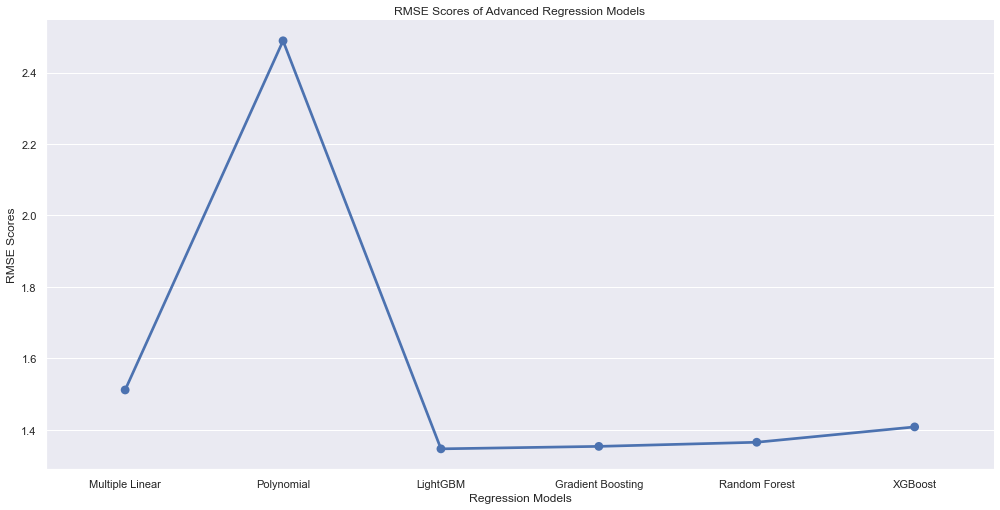

In [57]:
# Plot to show RMSE scores for all 6 models
sns.catplot(x = 'Regression Models', y = 'RMSE Scores', order = ['Multiple Linear', 'Polynomial', 'LightGBM', 'Gradient Boosting', 'Random Forest', 'XGBoost'],
           data = results_test, kind='point', height = 7, aspect = 2)
plt.title('RMSE Scores of Advanced Regression Models')
plt.xticks(rotation = 0)
plt.show()

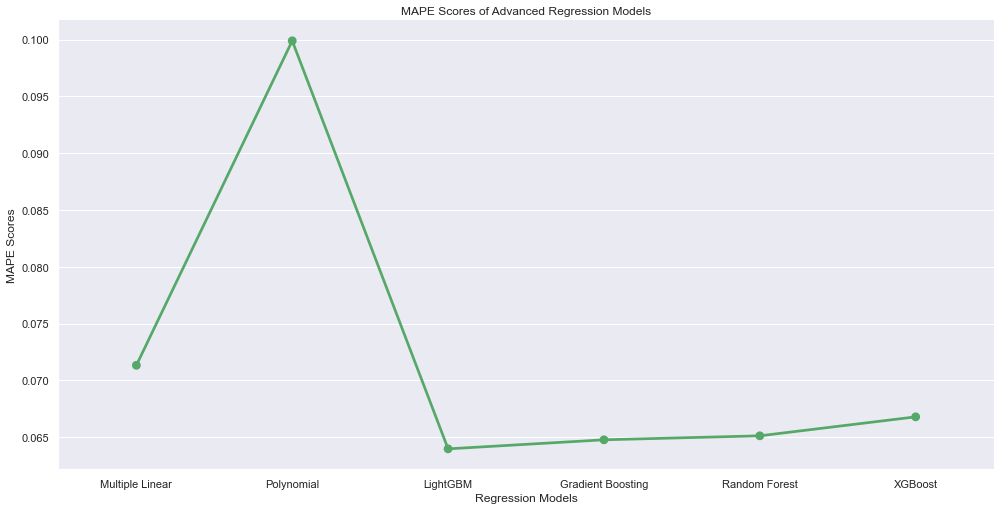

In [58]:
# Plot to show MAPE scores for all 6 models
sns.catplot(x = 'Regression Models', y = 'MAPE Scores', order = ['Multiple Linear', 'Polynomial', 'LightGBM', 'Gradient Boosting', 'Random Forest', 'XGBoost'],
           data = results_test, kind='point',color = 'g', height = 7, aspect = 2)
plt.title('MAPE Scores of Advanced Regression Models')
plt.xticks(rotation = 0)
plt.show()

## Top Performing Models
We have identified our Top 4 models: `LightGBM`, `Gradient Boosting`, `Random Forest` and `XGBoost` with relatively similar scores

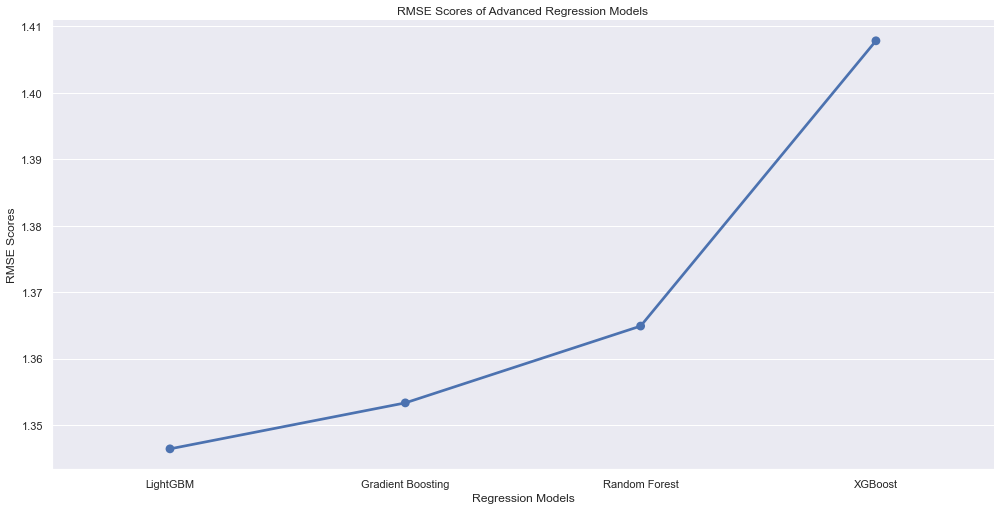

In [59]:
# Closer look at top performing models
sns.catplot(x = 'Regression Models', y = 'RMSE Scores', order = ['LightGBM', 'Gradient Boosting', 'Random Forest', 'XGBoost'],
           data = results_test, kind='point', color = 'b', height = 7, aspect = 2)
plt.title('RMSE Scores of Advanced Regression Models')
plt.xticks(rotation = 0)
plt.show()

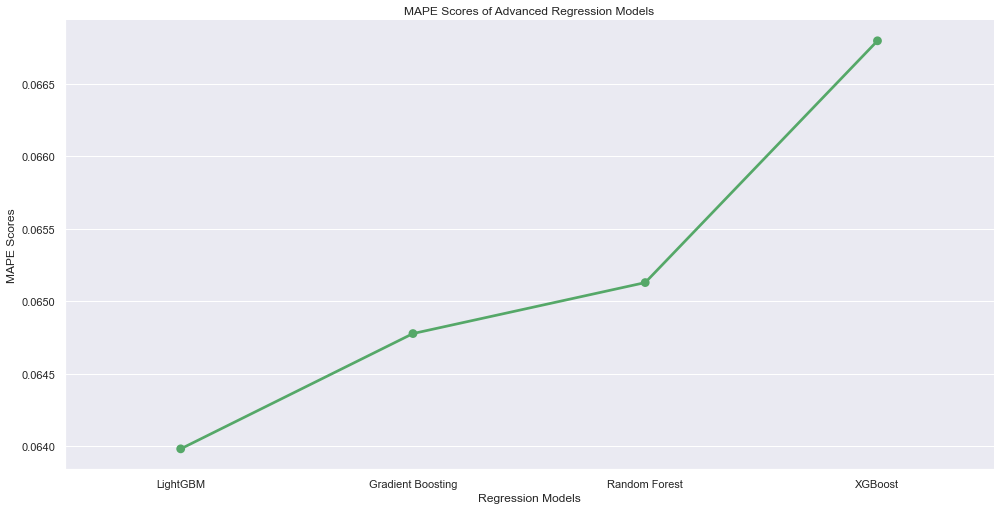

In [60]:
# Closer look at top performing models
sns.catplot(x = 'Regression Models', y = 'MAPE Scores', order = ['LightGBM', 'Gradient Boosting', 'Random Forest', 'XGBoost'],
           data = results_test, kind='point',color = 'g', height = 7, aspect = 2)
plt.title('MAPE Scores of Advanced Regression Models')
plt.xticks(rotation = 0)
plt.show()

## Fitting and Predicting with our models
We will fit the train set data to each of our models, then predict the `gross`.

In [61]:
# Fitting gbr to train set
gbr.fit(X_train,y_train)
gbr_y_test_pred = gbr.predict(X_test)

# Fitting xgbr to train set
xgbr.fit(X_train,y_train)
xgbr_y_test_pred = xgbr.predict(X_test)

# Fitting lgbm to train set
lgbm.fit(X_train,y_train)
lgbm_y_test_pred = lgbm.predict(X_test)

# Fitting rfr to train set
rfr.fit(X_train,y_train)
rfr_y_test_pred = rfr.predict(X_test)

## Visualising our results
We will now compare the predicted results of each model with the actual values.

### Create dataframe for predictions
We will collate all the results into a dataframe, including actual values of `gross`.

In [62]:
predicted = pd.DataFrame()

In [63]:
predicted['actual'] = y_test.values.reshape(-1)
predicted['gbr'] = gbr_y_test_pred.reshape(-1)
predicted['xgbr'] = xgbr_y_test_pred.reshape(-1)
predicted['lgbm'] = lgbm_y_test_pred.reshape(-1)
predicted['rfr'] = rfr_y_test_pred.reshape(-1)

### Overview of Fit
Below we will look at the fit of our model with our test data.

We will be plotting a scatter plot of our predicted values for `gross` 

<br>

**Actual (y-Axis)** vs **Predicted (x-Axis)**

<br>



We have plotted **2 lines** of different colours:
- **Black**: Ideal scenario where there is 0 error in prediction 


- **Red**: Best fit line of the model

The **vertical distance** between the points and the Black line represents the error in Predicted vs Actual values

<img src="https://github.com/chengyaolee/SC1015-DSAI-Project/blob/main/images/Predicted%20VS%20Actual%20Scatter.png?raw=true" width="800" height="800">

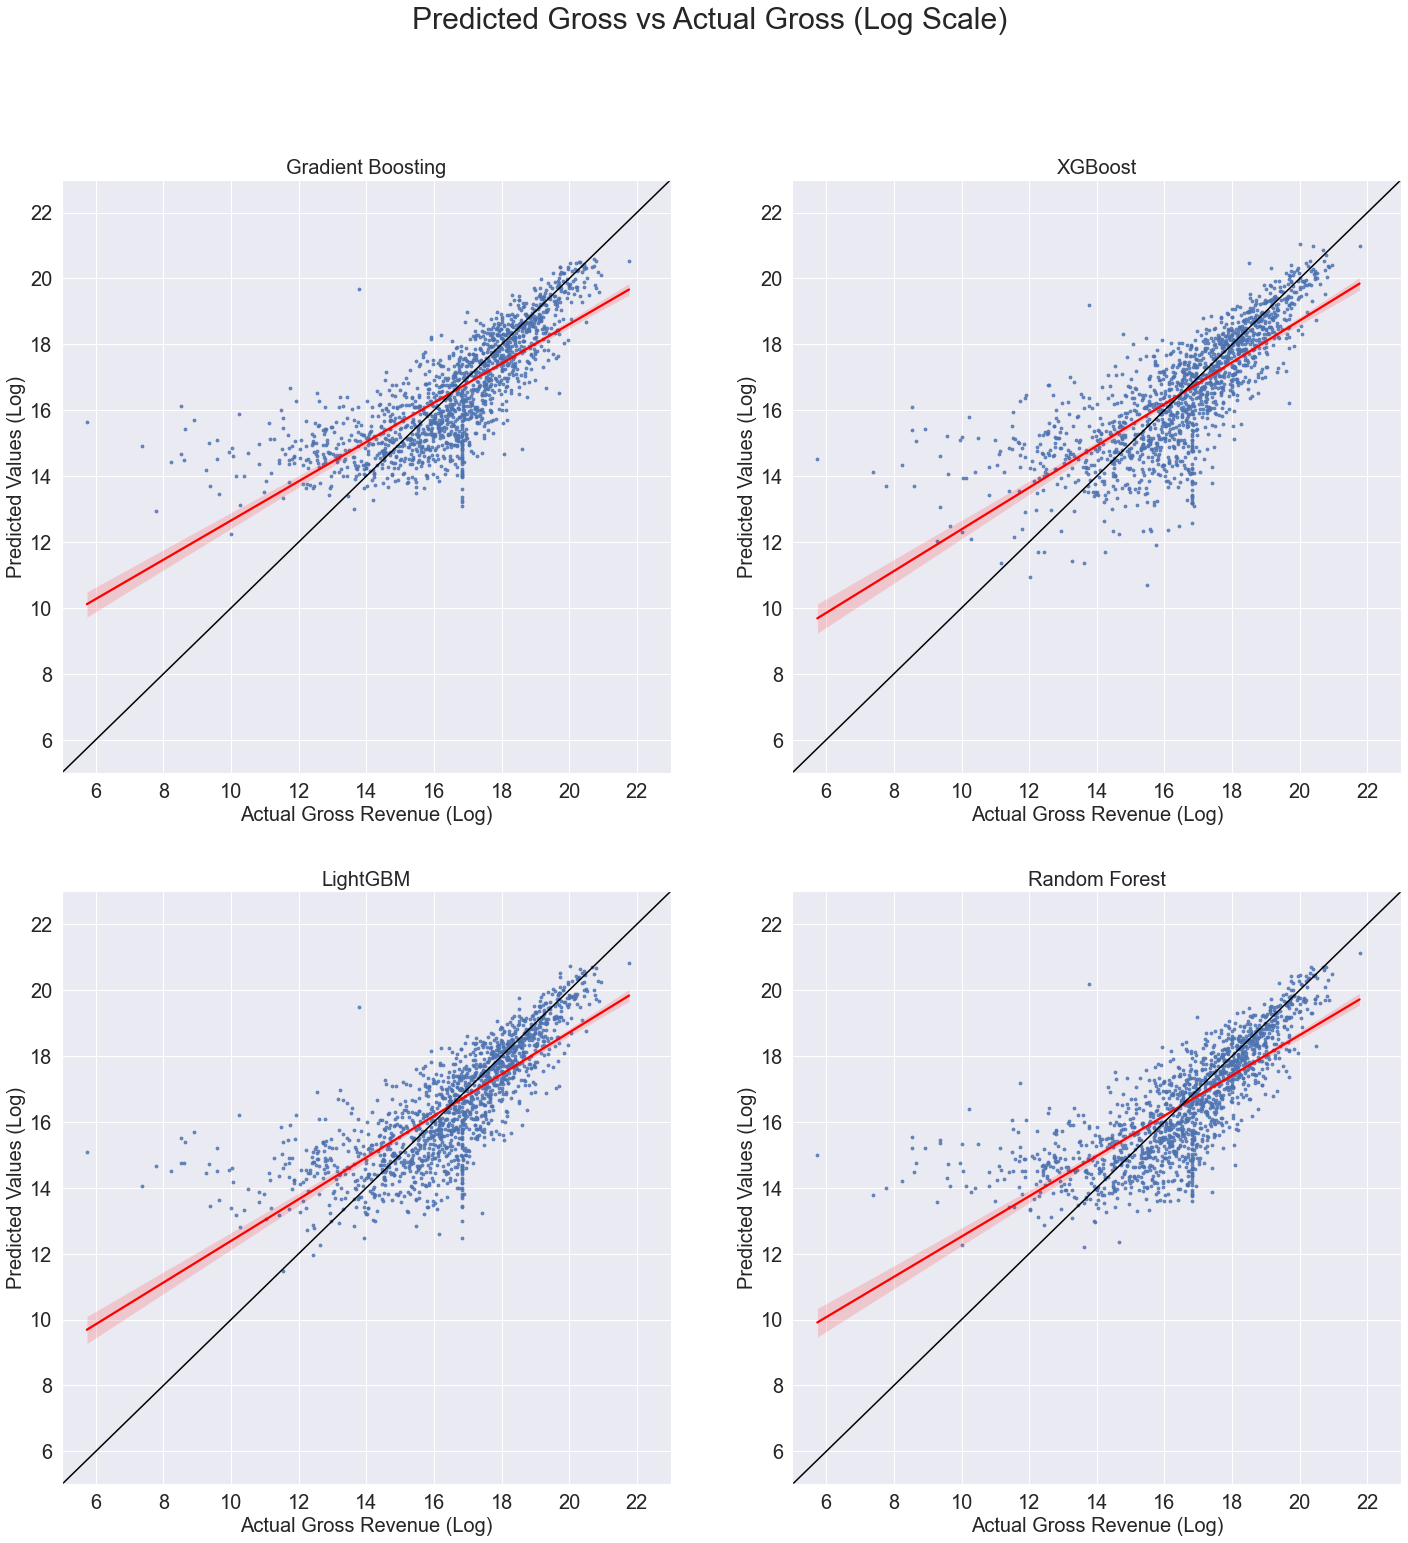

In [64]:
f,ax = plt.subplots(2,2,figsize=(24,24))
f.suptitle('Predicted Gross vs Actual Gross (Log Scale)',fontsize=30)

# Plot of predicted against actual for gbr
sns.regplot(ax = ax[0][0],x = 'actual', y = 'gbr', scatter_kws={'s':8}, line_kws={"color": "red"}, data = predicted)
ax[0][0].set_title("Gradient Boosting",fontsize=20)
ax[0][0].set_xlabel("Actual Gross Revenue (Log)",fontsize=20)
ax[0][0].set_ylabel("Predicted Values (Log)",fontsize=20)
ax[0][0].set_xlim(5,23)
ax[0][0].set_ylim(5,23)
ax[0][0].axline((20,20), slope=1, color="black")
ax[0][0].tick_params(axis='both', which='major', labelsize=20)
ax[0][0].tick_params(axis='both', which='minor', labelsize=20)

# Plot of predicted against actual for xgbr
sns.regplot(ax = ax[0][1],x = 'actual', y = 'xgbr', scatter_kws={'s':8}, line_kws={"color": "red"}, data = predicted)
ax[0][1].set_title("XGBoost",fontsize=20)
ax[0][1].set_xlabel("Actual Gross Revenue (Log)",fontsize=20)
ax[0][1].set_ylabel("Predicted Values (Log)",fontsize=20)
ax[0][1].set_xlim(5,23)
ax[0][1].set_ylim(5,23)
ax[0][1].axline((20,20), slope=1, color="black")
ax[0][1].tick_params(axis='both', which='major', labelsize=20)
ax[0][1].tick_params(axis='both', which='minor', labelsize=20)

# Plot of predicted against actual for lgbm
sns.regplot(ax = ax[1][0],x = 'actual', y = 'lgbm', scatter_kws={'s':8}, line_kws={"color": "red"}, data = predicted)
ax[1][0].set_title("LightGBM",fontsize=20)
ax[1][0].set_xlabel("Actual Gross Revenue (Log)",fontsize=20)
ax[1][0].set_ylabel("Predicted Values (Log)",fontsize=20)
ax[1][0].set_xlim(5,23)
ax[1][0].set_ylim(5,23)
ax[1][0].axline((20,20), slope=1, color="black")
ax[1][0].tick_params(axis='both', which='major', labelsize=20)
ax[1][0].tick_params(axis='both', which='minor', labelsize=20)

# Plot of predicted against actual for rfr
sns.regplot(ax = ax[1][1],x ='actual', y = 'rfr', scatter_kws={'s':8}, line_kws={"color": "red"}, data = predicted)
ax[1][1].set_title("Random Forest",fontsize=20)
ax[1][1].set_xlabel("Actual Gross Revenue (Log)",fontsize=20)
ax[1][1].set_ylabel("Predicted Values (Log)",fontsize=20)
ax[1][1].set_xlim(5,23)
ax[1][1].set_ylim(5,23)
ax[1][1].axline((20,20), slope=1, color="black")
ax[1][1].tick_params(axis='both', which='major', labelsize=20)
ax[1][1].tick_params(axis='both', which='minor', labelsize=20)


# Hyperparameters Tuning

## GridSearchCV

We will be running GridSearchCV to iterate through a selection of hyperparameters to determine the best hyperparameters that will give us the optimal result

For each model we will be running 3 folds of cross validations

### LBGM gridsearch

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

lgbmr = LGBMRegressor()

# Define the hyperparameters to tune for each base model and the meta model
lgbm_params = {
    'num_leaves': [10, 31],             
    'max_depth' : [-1, 3],         
    'reg_alpha': [0,0.1],            
    'min_data_in_leaf': [10, 20],  
    'lambda': [0, 0.1],                
    'learning_rate': [0.05, 0.1]   
}

# Best Hyperparameters:  LightGBMRegressor(num_leaves = 10, max_depth = 3, reg_alpha = 0.0, min_data_in_leaf = 20,
#                                             lambda_l2 = 0.0, learning_rate = 0.05)

gridsearch_kf = KFold(n_splits=3, shuffle=True, random_state=1015).split(X=X_train, y=y_train)

# Perform grid search with cross-validation on the stacking ensemble model
grid_search = GridSearchCV(lgbmr, param_grid=lgbm_params, scoring='neg_mean_squared_error', cv=gridsearch_kf)
grid_search.fit(X_train, y_train.values.ravel())

# Use the best estimator from the grid search to make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the performance of the final model on the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
print("RMSE score on test set: {:.4f}".format(rmse))
print("MAPE score on test set: {:.4f}".format(mape))
print("Best Hyperparameters: ", grid_search.best_estimator_)

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l2 is set wi

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set wi

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0. Current value: lambda_l2=0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l2 is set wi

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.1. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.1. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.1. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.1. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lam

### RFR gridsearch

In [ ]:
from sklearn.model_selection import GridSearchCV

rfr = RandomForestRegressor()

# Define the hyperparameters to tune for each base model and the meta model
rfr_params = {
    'n_estimators' : [80,100],
    'max_features' : ['log2','sqrt'],
    'max_depth' : [None,50],    
    'min_samples_split' : [2,4],    
    'min_samples_leaf' : [1,2]    
}

# Best Hyperparameters:  RandomForestRegressor(n_estimators = 100, max_features = 'log2', max_depth = None, min_samples_split = 2, 
#                                             min_samples_leaf = 1)

gridsearch_kf = KFold(n_splits=3, shuffle=True,random_state=1015).split(X=X_train, y=y_train)

# Perform grid search with cross-validation on the stacking ensemble model
grid_search = GridSearchCV(rfr, param_grid=rfr_params, scoring='neg_mean_squared_error', cv=gridsearch_kf)
grid_search.fit(X_train, y_train.values.ravel())

# Use the best estimator from the grid search to make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the performance of the final model on the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
print("RMSE score on test set: {:.4f}".format(rmse))
print("MAPE score on test set: {:.4f}".format(mape))
print("Best Hyperparameters: ", grid_search.best_estimator_)


### XGBoost gridsearch

In [ ]:
from sklearn.model_selection import GridSearchCV
xgbr = XGBRegressor()

# Define the hyperparameters to tune
xgbr_params = {
    'min_child_weight': [1, 50],   
    'learning_rate': [0.05, 0,1],                       
    'subsample': [1],                     
    'colsample_bytree': [0.5, 1],       
    'max_depth': [6, 12],                 
}

# Best Hyperparameters:  XGBoostingRegressor(min_child_weight = 50, learning_rate=0.05, subsample = 1, 
#                                             colsample_bytree = 1, max_depth=12)

gridsearch_kf = KFold(n_splits=3, shuffle=True,random_state=1015).split(X=X_train, y=y_train)

# Perform grid search with cross-validation on the stacking ensemble model
grid_search = GridSearchCV(xgbr, param_grid=xgbr_params, scoring='neg_mean_squared_error', cv=gridsearch_kf)
grid_search.fit(X_train, y_train.values.ravel())

# Use the best estimator from the grid search to make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the performance of the final model on the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
print("RMSE score on test set: {:.4f}".format(rmse))
print("MAPE score on test set: {:.4f}".format(mape))
print("Best Hyperparameters: ", grid_search.best_estimator_)


### GBM Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

gbm = GradientBoostingRegressor()

# Define the hyperparameters to tune
gbm_params = {
    'n_estimators': [100, 1000],
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 8],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 5],
    'max_features': ['sqrt', 'log2']
}

# Best Hyperparameters:  GradientBoostingRegressor(learning_rate=0.01, max_depth=8, max_features='log2',
#                          min_samples_leaf=5, min_samples_split=5,
#                          n_estimators=1000)

gridsearch_kf = KFold(n_splits=3, shuffle=True, random_state=1015).split(X=X_train, y=y_train)

# Perform grid search with cross-validation
gbm_grid_search = GridSearchCV(gbm, param_grid=gbm_params, scoring='neg_mean_squared_error', cv=gridsearch_kf)
gbm_grid_search.fit(X_train, y_train.values.ravel())

# Use the best estimator from the grid search to make predictions on the test set
gbm_gscv_y_pred = gbm_grid_search.best_estimator_.predict(X_test)

# Evaluate the performance of the final model on the test set
gbm_gscv_rmse = np.sqrt(mean_squared_error(y_test, gbm_gscv_y_pred))
gbm_gscv_mape = mean_absolute_percentage_error(y_test, gbm_gscv_y_pred)
print("RMSE score on test set: {:.4f}".format(gbm_gscv_rmse))
print("MAPE score on test set: {:.4f}".format(gbm_gscv_mape))
print("Best Hyperparameters: ", gbm_grid_search.best_estimator_)

## Grid Search Evaluation

We will now compare the results of Grid Search by visualising the performance of the default model and the improved model with optimised hyperparameters

### Results Before Grid Search

We will remove `Muliple Linear` and `Polynomial` from our comparisons as we have excluded them from our Grid Search

In [ ]:
# Table of results
results_test

In [ ]:
# Removing Multiple Linear and Polynomial from comparisons
results_test_before = results_test.drop([0,1],axis = 0)
results_test_before

## Results After Grid Search

We will recalculate our RMSE and MAPE scores after using the optimal hyperparameters from Grid Search 

#### Initialising Models with optimal parameters
To evaluate our models' performance after, we will initialise our models with the optimal hyperparameters provided by Grid Search

In [ ]:
lgbm_optimal = LGBMRegressor(num_leaves=10, max_depth=3, min_data_in_leaf=20, reg_alpha=0, lambda_l2=0, learning_rate = 0.05)
# perform cross-validation and calculate RMSE scores
lgbm_optimal_mse_cv = - cross_val_score(lgbm_optimal, X_train,y_train,cv = kf, scoring = 'neg_mean_squared_error',n_jobs = -1)
lgbm_optimal_rmse_cv = np.sqrt(lgbm_optimal_mse_cv)
# perform cross-validation and calculate MAPE scores
lgbm_optimal_mape_cv = cross_val_score(lgbm_optimal, X_train, y_train, cv=kf, scoring=mape_scorer)

gbr_optimal =  GradientBoostingRegressor(learning_rate = 0.01, max_depth = 8, max_features = 'log2', min_samples_split = 5, min_samples_leaf = 5, n_estimators = 1000)
# perform cross-validation and calculate RMSE scores
gbr_optimal_mse_cv = - cross_val_score(gbr_optimal, X_train,y_train,cv = kf, scoring = 'neg_mean_squared_error',n_jobs = -1)
gbr_optimal_rmse_cv = np.sqrt(gbr_optimal_mse_cv)
# perform cross-validation and calculate MAPE scores
gbr_optimal_mape_cv = cross_val_score(gbr_optimal, X_train, y_train, cv=kf, scoring=mape_scorer)

rfr_optimal = RandomForestRegressor(n_estimators = 100, max_depth = None, min_samples_split = 2, min_samples_leaf = 1)
# perform cross-validation and calculate RMSE scores
rfr_optimal_mse_cv = - cross_val_score(rfr_optimal, X_train,y_train,cv = kf, scoring = 'neg_mean_squared_error',n_jobs = -1)
rfr_optimal_rmse_cv = np.sqrt(rfr_optimal_mse_cv)
# perform cross-validation and calculate MAPE scores
rfr_optimal_mape_cv = cross_val_score(rfr_optimal, X_train, y_train, cv=kf, scoring=mape_scorer)

xgbr_optimal = XGBRegressor(min_child_weight = 50, learning_rate = 0.05, subsample = 1, colsample_bytree = 1, max_depth = 12)
# perform cross-validation and calculate RMSE scores
xgbr_optimal_mse_cv = - cross_val_score(xgbr_optimal, X_train,y_train,cv = kf, scoring = 'neg_mean_squared_error',n_jobs = -1)
xgbr_optimal_rmse_cv = np.sqrt(xgbr_optimal_mse_cv)
# perform cross-validation and calculate MAPE scores
xgbr_optimal_mape_cv = cross_val_score(xgbr_optimal, X_train, y_train, cv=kf, scoring=mape_scorer)

In [ ]:
print("RMSE CV set (After GridSeach)")
models = ['LightGBM','Gradient Boosting', 'Random Forest', 'XGBoost']

rmse_scores_after = [lgbm_optimal_rmse_cv.mean(), gbr_optimal_rmse_cv.mean(), rfr_optimal_rmse_cv.mean(), xgbr_optimal_rmse_cv.mean()]
mape_scores_after = [lgbm_optimal_mape_cv.mean(), gbr_optimal_mape_cv.mean(), rfr_optimal_mape_cv.mean(), xgbr_optimal_mape_cv.mean()]
# Creating dataframe for scores after grid search
model_scores_TEST_after = pd.DataFrame({
    'Regression Models' : models,
    'RMSE Scores' : rmse_scores_after,
    'MAPE Scores' : mape_scores_after

})

results_test_after = model_scores_TEST_after
results_test_after

## Visualising Changes

In [ ]:
x = results_test_after["Regression Models"]

plt.figure(figsize=(20,10))
# Plot line graph for MAPE before running grid search
plt.plot(x,results_test_before.iloc[:,-1], marker='o', color='b', label='Before')
# Plot line graph for MAPE after running grid search
plt.plot(x,results_test_after.iloc[:,-1], marker='o', color='g', label='After')
plt.legend()
plt.xticks(rotation = 0)
plt.title('Percentage Error (MAPE) of Advanced Regression Models (Before vs After GridSearch)',fontsize=20)
plt.xlabel("Regression Models",fontsize=20)
plt.xticks(fontsize=17)
plt.ylabel("Percentage Error",fontsize=20)
plt.yticks(fontsize=17)
plt.legend(fontsize=25)
plt.show()  

## While you are waiting for the code to complete its run, enjoy watching nyan cat run instead!

<img src="nyanc.webp" width="800" height="400">

# Ensemble Learning
We will be using the Stacking Regressor Ensemble learning model stack the output of individual estimator models and use a regressor to compute the final prediction. 

Stacking allows us to use the strength of each individual estimator by using their output as input of a final estimator.

<img src="https://editor.analyticsvidhya.com/uploads/39725Stacking.png" width="800" height="350">

In [ ]:
from sklearn.ensemble import StackingRegressor
# Passing in optimal models as estimators
base_models = [
    ('gbr', gbr_optimal),
    ('rfr', rfr_optimal),
    ('xgbr',xgbr_optimal)
]


# Define the stacking ensemble model
stacking_regressor = StackingRegressor(estimators = base_models, final_estimator=lgbm_optimal)
# Calculating RMSE and MAPE for stacking regressor
stacking_mse_cv_scores = - cross_val_score(stacking_regressor, X_train,y_train,cv = kf, scoring = 'neg_mean_squared_error',n_jobs = -1)
stacking_rmse_cv_scores = np.sqrt(stacking_mse_cv_scores)

stacking_mape_cv_scores = cross_val_score(stacking_regressor, X_train, y_train, cv=kf, scoring=mape_scorer)

print("RMSE: ", stacking_rmse_cv_scores.mean())
print("MAPE: ", stacking_mape_cv_scores.mean())

# Final Evaluation of Models

### Appending Results of Ensemble Learning

In [ ]:
# Add results of stacking regressor to dataframe
results_test_after_stacking = results_test_after.append({'Regression Models': 'Stacking Regressor', 'RMSE Scores': stacking_rmse_cv_scores.mean(), 'MAPE Scores': stacking_mape_cv_scores.mean()}, ignore_index= True)
results_test_after_stacking

### Visualising the Results

In [ ]:
# Plot of 4 base models and meta models for RMSE
sns.catplot(x = 'Regression Models', y = 'RMSE Scores', order = ['LightGBM', 'Gradient Boosting', 'Random Forest', 'XGBoost', 'Stacking Regressor'],
           data = results_test_after_stacking, kind='point', height = 7, aspect = 2)
plt.title('RMSE Scores of Advanced Regression Models')
plt.xticks(rotation = 0)
plt.show()

In [ ]:
# Plot of 4 base models and meta models for MAPE
sns.catplot(x = 'Regression Models', y = 'MAPE Scores', order = ['LightGBM', 'Gradient Boosting', 'Random Forest', 'XGBoost', 'Stacking Regressor'],
           data = results_test_after_stacking, kind='point',color = 'g', height = 7, aspect = 2)
plt.title('MAPE Scores of Advanced Regression Models')
plt.xticks(rotation = 0)
plt.show()

# Prediction of Gross Revenue

Now that we have optimised our hyperparameters for our models and stacked our regressors together through Ensemble Learning, we are ready to predict the performance of our movies.

We will use the sample of 3 movies that we have saved at the start of the notebook that are not present in either the train or test sets.

In [ ]:
test_sample = sample
test_name = sample["name"]
test_sample

In [ ]:
#Drop columns not used for prediction
test_sample = test_sample.drop(['released','year'],axis = 1)

#Log transform numeric variables
test_sample['budget'] = np.log1p(test_sample['budget'])
test_sample['votes'] = np.log1p(test_sample['votes'])
test_sample['runtime'] = np.log1p(test_sample['runtime'])
test_sample['gross'] = np.log1p(test_sample['gross'])

#Encode categorical variables
cat_var_encode = ['director', 'writer', 'rating', 'genre', 'name', 'star', 'country', 'company']
test_sample[cat_var_encode] = oe.transform(test_sample[cat_var_encode])

In [ ]:
# Splitting sample to predictor and response
X_test_sample = test_sample.iloc[:,:-1]
Y_test_sample = test_sample['gross']
X_test_sample 

In [ ]:
stacking_regressor = StackingRegressor(estimators = base_models, final_estimator=lgbm_optimal)

# Fit the stacking regressor to train data set
stacking_regressor.final_estimator.fit(X_train,y_train)
sample_results = stacking_regressor.final_estimator.predict(X_test_sample)
sample_results

In [ ]:
# Summarize the Actuals, Predictions and Errors
sample_results = pd.DataFrame(sample_results, columns = ["PredGrossRevenue"], index = X_test_sample.index)
revenue_acc = pd.concat([pd.DataFrame(test_name),Y_test_sample, sample_results], axis = 1)

y_errs = 100 * abs(revenue_acc["PredGrossRevenue"] - revenue_acc["gross"]) / revenue_acc["gross"]
y_errs = pd.DataFrame(y_errs, columns = ["% Error"], index = X_test_sample.index)
revenue_acc = pd.concat([revenue_acc, y_errs], axis = 1)

revenue_acc.round(4)